# GPU 확인

xgboost 사용할 때 gpu사용할 수 있음

In [ ]:
!nvidia-smi

# 한글 글씨체 다운로드


In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 5 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (20.1 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


# 사용할 라이브러리 불러오기

In [1]:
#기본
import pandas as pd
import numpy as np
import math
import json

#메모리 클리어
import gc


#시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 


#모델
from sklearn.ensemble import RandomForestRegressor
import xgboost
import lightgbm as lgb
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression


#하이퍼 파라미터 찾기
from sklearn.model_selection import GridSearchCV


#검증 및 평가모델
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

#평가 방법

평가 산식 : MAE


4. 외부 데이터 및 사전 학습 모델

사용에 법적 제약이 없고 누구나 사용할 수 있는 외부 데이터 사용 가능
외부 데이터는 2022년 8월 이전의 데이터만 사용 가능
법적 제약이 없으며 공개된 사전 학습 모델(Pre-trained Model) 사용 가능

# Parquet 변환

csv보다 더 효율적인 데이터 형태이다.

In [ ]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'/content/drive/MyDrive/jeju_traffic/{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

csv_to_parquet('/content/drive/MyDrive/jeju_traffic/train_preprocess.csv', 'train_preprocess')
csv_to_parquet('/content/drive/MyDrive/jeju_traffic/validation_preprocess.csv', 'validation_preprocess')
csv_to_parquet('/content/drive/MyDrive/jeju_traffic/test_preprocess.csv', 'test_preprocess')

# 데이터 확인


1. 변수 설명
2. 타입 확인
3. 오브젝트타입 원소들 확인
4. 결측치 존재 유무
5. 간단한 분포 확인
6. 더 생각해볼만한 변수

In [ ]:
df_train=pd.read_parquet('/content/drive/MyDrive/jeju_traffic/train.parquet')
df_train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,20211104,목,16,1,107,-,0,0,50.0,...,0,대림사거리,33.422145,126.278125,없음,금덕해운,33.420955,126.273750,없음,20.0
4701213,TRAIN_4701213,20220331,목,2,2,107,-,0,0,80.0,...,3,광삼교,33.472505,126.424368,없음,광삼교,33.472525,126.424890,없음,65.0
4701214,TRAIN_4701214,20220613,월,22,2,103,일반국도12호선,0,0,60.0,...,0,고성교차로,33.447183,126.912579,없음,성산교차로,33.444121,126.912948,없음,30.0
4701215,TRAIN_4701215,20211020,수,2,2,103,일반국도95호선,0,0,80.0,...,0,제6광령교,33.443596,126.431817,없음,관광대학입구,33.444996,126.433332,없음,73.0


## 1. 변수설명

In [ ]:
info=pd.read_csv('/content/drive/MyDrive/jeju_traffic/data_info.csv')
info

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


## 2. 타입확인

In [ ]:
#범주형 데이터
# 요일
# 길 이름
# 시작점 이름
# 끝점 이름
# 제한

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

## 3. 범주형 컬럼 확인

In [ ]:
# 범주형 데이터중 다른 카테고리가 있는지?

str_data=[]

for i in df_train.columns:
  print(i+': ',df_train[i].unique())
  print('요소 길이: ', len(df_train[i].unique()))
  print('===='*50)

  if str==type(df_train[i].unique()[0]):
    str_data.append(df_train[i].unique())



In [ ]:
for i in str_data:
  print(i)

## 4. 결측치 유무 확인

단순히 None이 아니라 다른 문자로 들어가 있지 않은지 확인이 필요함 이는 3번에서 확인할수 있음

In [ ]:
#단순 결측치 확인
df_train.isnull().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
target                   0
dtype: int64

In [ ]:
#'-' 가 road_name 결측치이니 다른곳은? -> road_name뿐이란걸 확인

for i in df_train.columns:

  if '-' in df_train[i].unique():
    print(df_train[i].unique())
    print(i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


['지방도1112호선' '일반국도11호선' '일반국도16호선' '태평로' '일반국도12호선' '경찰로' '-' '외도천교'
 '일반국도99호선' '중정로' '번영로' '연동로' '중산간서로' '지방도1118호선' '새서귀로' '지방도1115호선'
 '지방도1132호선' '어시천교' '지방도1120호선' '삼무로' '애조로' '지방도1116호선' '일반국도95호선'
 '동부관광도로' '동홍로' '지방도97호선' '중문로' '연삼로' '중앙로' '산서로' '지방도1117호선' '연북로' '남조로'
 '지방도1119호선' '동문로' '한천로' '삼봉로' '고평교' '연북2교' '관광단지로' '권학로' '시청로' '신대로'
 '서사로' '관덕로' '관광단지1로' '신산로' '관광단지2로' '신광로' '지방도1136호선' '첨단로' '제2거로교'
 '시민광장로' '임항로' '수영장길' '애원로' '삼성로' '일주동로' '호서중앙로' '아봉로' '호근로']
road_name


In [ ]:
#테스트에도 road_name이 -인 경우가 존재

df_test=pd.read_parquet('/content/drive/MyDrive/jeju_traffic/test.parquet')
df_test.road_name.unique()

array(['연삼로', '일반국도12호선', '일반국도16호선', '일반국도11호선', '번영로', '수영장길', '-',
       '지방도1136호선', '제2거로교', '일반국도99호선', '경찰로', '시청로', '서사로', '관광단지1로',
       '신산로', '새서귀로', '중문로', '지방도1132호선', '태평로', '산서로', '관광단지로', '중정로',
       '관광단지2로', '동홍로', '고평교', '애조로', '삼봉로', '외도천교', '권학로', '신대로', '삼성로',
       '지방도1118호선', '시민광장로', '지방도1115호선', '중앙로', '첨단로', '관덕로', '어시천교',
       '한천로', '동부관광도로', '연북2교', '동문로', '연북로', '연동로', '지방도1117호선',
       '지방도97호선'], dtype=object)

## 5. 간단한 분포 확인

20220603    20544
20220504    20460
20220602    20441
20220626    20429
20220609    20415
            ...  
20220315     2163
20211107     2071
20220730     1845
20220519     1558
20220518     1555
Name: base_date, Length: 281, dtype: int64


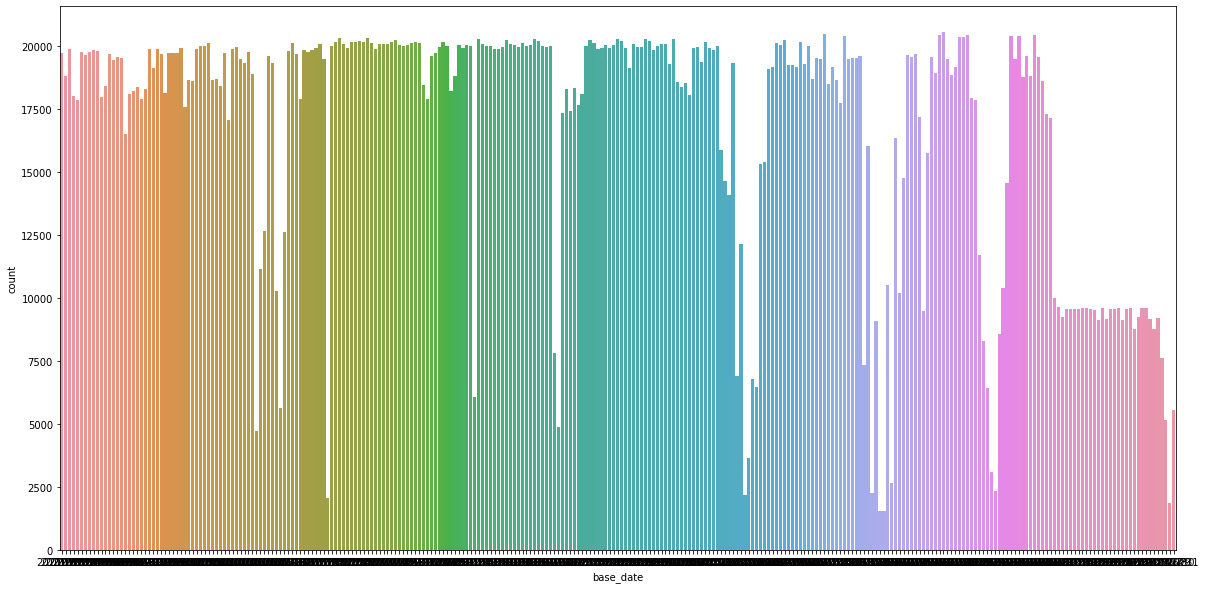

In [ ]:
#날짜별로 데이터가 균등하게 잡혀있진 않다.

print(df_train['base_date'].value_counts())

plt.figure(figsize=(20,10))
sns.countplot(x="base_date",data=df_train)
plt.show()

In [ ]:
# 대략적인 분포 파악 균등하게 분포 되어있는건  요일, 시간정도인것 같다.
# 값이 통일 되어있는것은 굳이 저장하고 있을 필요 없다. vehicle_restricted,
for i in df_train.columns: 
  
  print(df_train[i].value_counts())
  print('======'*100)

TRAIN_0000000    1
TRAIN_3134142    1
TRAIN_3134148    1
TRAIN_3134147    1
TRAIN_3134146    1
                ..
TRAIN_1567079    1
TRAIN_1567080    1
TRAIN_1567081    1
TRAIN_1567082    1
TRAIN_4701216    1
Name: id, Length: 4701217, dtype: int64
20220603    20544
20220504    20460
20220602    20441
20220626    20429
20220609    20415
            ...  
20220315     2163
20211107     2071
20220730     1845
20220519     1558
20220518     1555
Name: base_date, Length: 281, dtype: int64
금    684024
수    675583
목    674070
일    673632
토    669767
화    662498
월    661643
Name: day_of_week, dtype: int64
15    214541
13    214297
14    214182
12    211833
19    209870
11    208515
16    208420
17    208377
18    207500
10    206316
9     205327
20    205059
21    203585
8     201875
22    200629
7     199061
6     189418
23    184229
1     182353
5     181128
2     169322
4     165284
3     155938
0     154158
Name: base_hour, dtype: int64
2    2352092
1    1558531
3     790594
Name: lane_co

In [ ]:
# 속도 제한을 어기는 경우가 많을까? 생각보다 많은 듯하다 

df_train[df_train['maximum_speed_limit']<df_train['target']][['maximum_speed_limit','road_name','target']]

,maximum_speed_limit,road_name,target
9,50.0,일반국도16호선,52.0
15,30.0,일반국도16호선,32.0
28,50.0,-,59.0
69,60.0,지방도97호선,62.0
73,50.0,지방도1118호선,58.0
...,...,...,...
4701180,60.0,일반국도12호선,64.0
4701183,60.0,지방도97호선,65.0
4701185,60.0,지방도97호선,70.0
4701197,30.0,-,37.0


In [ ]:
#road_name이 같을때 maximum_speed_limit도 같은가? 그건 아닌듯하다. 같은 도로명이어도 최대속도는 다를수 있음
for i in df_train['road_name'].unique():
  print(i)
  print(df_train[df_train['road_name']==i][['maximum_speed_limit','road_name']]['maximum_speed_limit'].unique())

지방도1112호선
[60. 30.]
일반국도11호선
[60. 70. 30.]
일반국도16호선
[80. 50. 60. 30. 70.]
태평로
[50.]
일반국도12호선
[80. 70. 50. 60. 40. 30.]
경찰로
[60.]
-
[60. 50. 80. 30. 70.]
외도천교
[60.]
일반국도99호선
[60. 70. 30.]
중정로
[50.]
번영로
[70.]
연동로
[50.]
중산간서로
[70. 50.]
지방도1118호선
[60. 50. 70.]
새서귀로
[60. 30.]
지방도1115호선
[60.]
지방도1132호선
[70. 50. 60.]
어시천교
[60.]
지방도1120호선
[50. 30. 60.]
삼무로
[50.]
애조로
[80.]
지방도1116호선
[80.]
일반국도95호선
[80. 40.]
동부관광도로
[50.]
동홍로
[50. 60.]
지방도97호선
[60.]
중문로
[50.]
연삼로
[70.]
중앙로
[60. 70.]
산서로
[60. 50.]
지방도1117호선
[60.]
연북로
[30. 50.]
남조로
[60. 50.]
지방도1119호선
[60.]
동문로
[50.]
한천로
[60.]
삼봉로
[60.]
고평교
[50.]
연북2교
[70.]
관광단지로
[30.]
권학로
[60.]
시청로
[60.]
신대로
[70. 30.]
서사로
[30. 50.]
관덕로
[60.]
관광단지1로
[30.]
신산로
[60.]
관광단지2로
[30.]
신광로
[50.]
지방도1136호선
[60.]
첨단로


KeyboardInterrupt: ignored

In [ ]:
#날짜에 따라 그것이 바뀌는가? X
df_train[df_train['road_name']=='일반국도12호선'][['base_date','maximum_speed_limit','road_name','target']]

In [ ]:
#start_node와 end_node의 집합이 다르다는 것을 알수있음

print(len(set(df_train['start_node_name'].unique())))
print(len(set(df_train['end_node_name'].unique())))
print(set(df_train['end_node_name'].unique())==set(df_train['start_node_name'].unique()))

print(set(df_train['start_node_name'].unique()))
print(set(df_train['end_node_name'].unique()))

print(set(df_train['end_node_name'].unique())-set(df_train['start_node_name'].unique()))
print(set(df_train['start_node_name'].unique())-set(df_train['end_node_name'].unique()))


In [ ]:
#start node와 end_node의 조합이 다양하지 않다는 것을 알수있음 또한 그에따라 road_name도 거의 비슷함


for i in df_train['start_node_name'].unique():
  print(i)
  print(df_train[df_train['start_node_name']==i]['end_node_name'].unique())
  print(df_train[df_train['start_node_name']==i]['road_name'].unique())
  print('====='*100)

## 다른 생각해볼만한 변수

1. 제주도 도로의 특징

 - 고속도로가 없다.

교통량의 수요는 과연 선형적인가? 

우리는 여기서 한가지 가설을 제시하려한다. 교통량이 계절성을 띈다는 것이다. 

제주도는 관광지로 유명한 장소이다. 

당연히 휴가철에는 제주도 유동인구가 더 많을 것이다. 

또한 날씨또한 영향을 끼치지 않겠는가?

제주도는 대다수의 사람이 대중교통보다는 자가를 많이 사용하는가?

날씨 데이터를 사용해보려 했으나 결국 예측력 높은 날씨 데이터가 있어야 의미가 있다고 판단하여 이는 구하지 않음


2. 날씨 / 불쾌지수 (1달치 예측 데이터 ㅇㄷ?)

3. 렌터카 (1달 예상 데이터 X)

4. 성수기 / 준성수기 / 비수기

5. 비행기 가격을 지표로

# 데이터 전처리

1. object type -> int or float 
   
   - 단순히 1,2,3,4로 인코딩하기
   - target의 평균으로 인코딩하기 (인코딩 하기전에 validation과 train분리 필요!!)
   - one hot encoding

2. 날짜 순서대로 배치 (validation데이터 뽑기위함)

3. 다중 공선성에 의해 column제거 <- decision tree 모델에서 과연 이것이 유효한가?
  이번 대회의 1차적인 목표는 예측력을 높이는 것이기에 일단은 모든 columns을 사용하려 한다.

    참고: https://gibles-deepmind.tistory.com/9

4. normalize(?) 후순위로 <- decision tree 모델 위주로 사용할것이라 생략



## 1. object type -> int or float

### 단순히 1,2,3,4....로 인코딩

In [ ]:


df_train=pd.read_parquet('/content/drive/MyDrive/jeju_traffic/train.parquet')

df_train=df_train.sort_values(by=['base_date']) #날짜 순서대로 배치

#시간에 따라 validation 생성 (우리가 예측하는 데이터는 8월 데이터이므로 7월 데이터들을 validation으로 채택)
df_validation=df_train[df_train['base_date']>20220700]
df_train=df_train[df_train['base_date']<20220700]

In [ ]:
week2int={label:i for i, label in enumerate(df_train['day_of_week'].unique())}
node2int={label:i for i, label in enumerate(set(df_train['start_node_name'].unique()) | set(df_train['end_node_name'].unique()))}
restrict2int={label:i for i, label in enumerate(df_train['end_turn_restricted'].unique())}
road2int ={label:i for i, label in enumerate(df_train['road_name'].unique())}

In [ ]:
df_train['month']=df_train['base_date'].apply(lambda x : (x%10000)//100) #월 생성
df_train['day']=df_train['base_date'].apply(lambda x : (x%10000)%100)  #일 생성

df_train['day_of_week']=df_train['day_of_week'].apply(lambda x : week2int[x])
df_train['road_name']=df_train['road_name'].apply(lambda x : road2int[x])
df_train['start_turn_restricted']=df_train['start_turn_restricted'].apply(lambda x : restrict2int[x])
df_train['end_turn_restricted']=df_train['end_turn_restricted'].apply(lambda x : restrict2int[x])
df_train['start_node_name']=df_train['start_node_name'].apply(lambda x : node2int[x])
df_train['end_node_name']=df_train['end_node_name'].apply(lambda x : node2int[x])


In [ ]:
df_train.to_parquet('/content/drive/MyDrive/jeju_traffic/train_preprocess.parquet',index=False)

In [ ]:
df_train=pd.read_parquet('/content/drive/MyDrive/jeju_traffic/train_preprocess.parquet')
df_train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,month,day
0,TRAIN_0430379,20210901,0,16,3,106,0,0,0,70.0,...,33.518987,126.568861,1,370,33.519726,126.571488,0,37.0,9,1
1,TRAIN_0369019,20210901,0,11,1,103,1,0,0,50.0,...,33.312509,126.703863,0,130,33.312449,126.696173,0,36.0,9,1
2,TRAIN_1132647,20210901,0,4,2,103,2,0,0,80.0,...,33.462214,126.326551,0,459,33.462677,126.330152,0,43.0,9,1
3,TRAIN_4543127,20210901,0,16,1,107,3,0,0,60.0,...,33.331742,126.676431,0,453,33.325096,126.665698,0,55.0,9,1
4,TRAIN_3428956,20210901,0,9,1,103,1,0,0,50.0,...,33.260056,126.490987,0,153,33.259995,126.491306,0,53.0,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426517,TRAIN_3951630,20220630,1,10,1,103,4,0,0,70.0,...,33.485489,126.542504,1,485,33.487633,126.540414,1,14.0,6,30
4426518,TRAIN_1586581,20220630,1,3,3,106,0,0,0,70.0,...,33.250576,126.478973,0,470,33.250441,126.479773,0,59.0,6,30
4426519,TRAIN_3665493,20220630,1,14,1,103,2,0,0,60.0,...,33.549330,126.778125,0,55,33.551585,126.769385,0,53.0,6,30
4426520,TRAIN_3371207,20220630,1,23,2,107,18,0,0,60.0,...,33.252183,126.506069,0,223,33.249949,126.505664,0,18.0,6,30


In [ ]:
# #테스트 셋들도 똑같이 encoding

# df_test['month']=df_test['base_date'].apply(lambda x : (x%10000)//100)
# df_test['day']=df_test['base_date'].apply(lambda x : (x%10000)%100)
# df_test['day_of_week']=df_test['day_of_week'].apply(lambda x : week2int[x])
# df_test['road_name']=df_test['road_name'].apply(lambda x : road2int[x])
# df_test['start_turn_restricted']=df_test['start_turn_restricted'].apply(lambda x : restrict2int[x])

# df_test['end_turn_restricted']=df_test['end_turn_restricted'].apply(lambda x : restrict2int[x])


# df_test['start_node_name']=df_test['start_node_name'].apply(lambda x : node2int[x])
# df_test['end_node_name']=df_test['end_node_name'].apply(lambda x : node2int[x])

NameError: ignored

In [ ]:
df

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


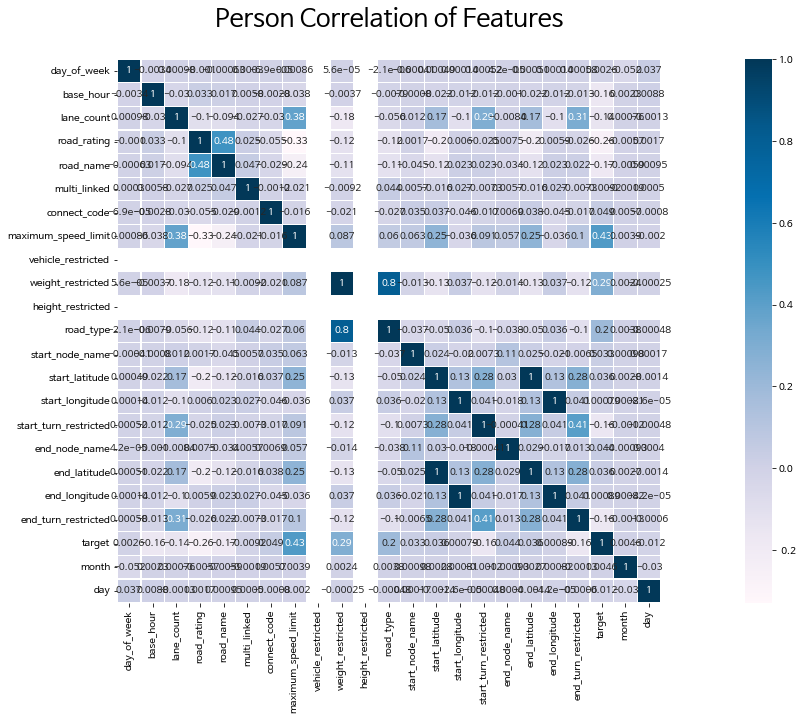

In [ ]:
colormap = plt.cm.PuBu
plt.figure(figsize=(30, 10))
plt.title("Person Correlation of Features", y = 1.05, size = 25)
sns.heatmap(df_train.drop(['id','base_date'],axis=1).astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 10})

### target 평균으로 인코딩

결국에 target을 예측하는 것이기에 각 범주의 데이터에 target에 관한 정보가 있었으면 했다. 예를들어 월,화,수,목,금,토,일 이 있다면 이를 단순히
1,2,3,4,5,6,7로 인코딩하지 않고

월요일 평균 target값, 화요일 평균 target값 ...이런식으로 인코딩했다.

여기서 주의할점은 validation 데이터 이전에 train데이터로만 평균값을 구해야하는 것이다. 만일 validation데이터를 포함하여 평균을 했다면 이는 dataleakage에 해당한다.

하지만 decision tree모델에서는 큰 효용을 보이진 못했다.

코드쓰기 힘들었는데 효과가 없어서 좀 슬프다.....

하지만 상관계수로 바꿨을때 두드러지는 columns들을 찾은 것에대하여 의미가 있을지도?


In [ ]:
df_train=pd.read_parquet('/content/drive/MyDrive/jeju_traffic/train.parquet')

df_train=df_train.sort_values(by=['base_date']) #날짜 순서대로 배치

#시간에 따라 validation 생성 (우리가 예측하는 데이터는 8월 데이터이므로 7월 데이터들을 validation으로 채택)
df_validation=df_train[df_train['base_date']>20220700]
df_train=df_train[df_train['base_date']<20220700]


#여기서 범주형 데이터만 골라서 쓰면 될것같다.
for i in df_train.columns:
  name2float={}

  for i,j in zip(df_train.groupby(i).mean()['target'].index,df_train.groupby(i).mean()['target']): #i: index, j: mean값
        name2float[i]=j

  with open('/content/drive/MyDrive/jeju_traffic/json/{}_mean.json'.format(i), 'w', encoding='utf-8') as f:
    json.dump(name2float,f,ensure_ascii=False, indent="\t")




KeyError: ignored

In [ ]:
# month 생성
# day 생성
# day_of_week 인코딩
# road_name 인코딩
# start_turn_restricted 인코딩
# end_turn_restricted 인코딩
# start_node_name 인코딩
# end_node_name 인코딩

import json

#json data 열기
file_path = "/content/drive/MyDrive/jeju_traffic/json/"
with open(file_path+"day_of_week_mean.json", encoding='utf-8') as f:
    day_of_week_encoder = json.load(f)
    print(day_of_week_encoder)

with open(file_path+"end_node_name_mean.json", encoding='utf-8') as f:
    end_node_name_encoder = json.load(f)
    print(end_node_name_encoder)

with open(file_path+"start_node_name_mean.json", encoding='utf-8') as f:
    start_node_name_encoder = json.load(f)
    print(start_node_name_encoder)

with open(file_path+"road_name_mean.json", encoding='utf-8') as f:
    road_name_encoder = json.load(f)
    print(road_name_encoder)

#####################################################


with open(file_path+"base_hour_mean.json", encoding='utf-8') as f:
    base_hour_encoder = json.load(f)
    print(base_hour_encoder)


with open(file_path+"lane_count_mean.json", encoding='utf-8') as f:
    lane_count_encoder = json.load(f)
    print(lane_count_encoder)



with open(file_path+"road_rating_mean.json", encoding='utf-8') as f:
    road_rating_encoder = json.load(f)
    print(road_rating_encoder)



with open(file_path+"multi_linked_mean.json", encoding='utf-8') as f:
    multi_linked_encoder = json.load(f)
    print(multi_linked_encoder)


#############################################################


with open(file_path+"connect_code_mean.json", encoding='utf-8') as f:
    connect_code_encoder = json.load(f)
    print(connect_code_encoder)


with open(file_path+"maximum_speed_limit_mean.json", encoding='utf-8') as f:
    maximum_speed_limit_encoder = json.load(f)
    print(maximum_speed_limit_encoder)



with open(file_path+"weight_restricted_mean.json", encoding='utf-8') as f:
    weight_restricted_encoder = json.load(f)
    print(weight_restricted_encoder)


with open(file_path+"height_restricted_mean.json", encoding='utf-8') as f:
    height_restricted_encoder = json.load(f)
    print(height_restricted_encoder)


with open(file_path+"road_type_mean.json", encoding='utf-8') as f:
    road_type_encoder = json.load(f)
    print(road_type_encoder)

with open(file_path+"start_turn_restricted_mean.json", encoding='utf-8') as f:
    start_turn_restricted_encoder = json.load(f)
    print(start_turn_restricted_encoder)

    
with open(file_path+"end_turn_restricted_mean.json", encoding='utf-8') as f:
    end_turn_restricted_encoder = json.load(f)
    print(end_turn_restricted_encoder)

with open(file_path+"vehicle_restricted_mean.json", encoding='utf-8') as f:
    vehicle_restricted_encoder = json.load(f)
    print(vehicle_restricted_encoder)

{'금': 42.87941979117228, '목': 43.140091650937634, '수': 43.17033172114848, '월': 43.16489927467514, '일': 43.60658185823153, '토': 43.290646990612046, '화': 43.098667255018576}
{'BYC': 25.045184168382523, 'CU서귀호근로점': 32.08688245315162, 'KAL사거리': 26.401534036433365, '가는질': 52.81818181818182, '가동': 28.629466223058007, '가마교': 36.69948678958373, '가시리': 31.730596757502585, '감귤선과장': 46.251173708920184, '감귤창고': 41.06275033377837, '강정교': 50.085340802987865, '강정동 163': 24.203476803853807, '거로마을': 32.986476333583774, '거로사거리': 38.31149690876163, '경동보일러': 25.74320788891125, '경마장교': 75.20880144000994, '경마장교차로': 76.02699683485385, '고림동4거리': 41.670436187399034, '고산전화국': 32.76779099239618, '고성교': 70.71582867783985, '고성교차로': 53.59966867826293, '고평교': 37.13554672720394, '고하상로교차로': 44.117995792694586, '관광단지입구': 38.573715810540364, '관광대학입구': 59.26121765034444, '관음교': 36.4977460555973, '관음사길': 31.246043707611154, '광덕아파트': 34.78494420276149, '광령1교차로': 43.72877023572848, '광령2교차로': 64.31843575418995, '광령3교차로': 58.

In [ ]:
df_train['month']=df_train['base_date'].apply(lambda x : (x%10000)//100)
df_train['day']=df_train['base_date'].apply(lambda x : (x%10000)%100)
df_train['day_of_week']=df_train['day_of_week'].apply(lambda x : day_of_week_encoder[x])
df_train['road_name']=df_train['road_name'].apply(lambda x : road_name_encoder[x])

# df_train['start_turn_restricted']=df_train['start_turn_restricted'].apply(lambda x : restrict_encoder[x])
# df_train['end_turn_restricted']=df_train['end_turn_restricted'].apply(lambda x : restrict_encoder[x])


df_train['start_node_name']=df_train['start_node_name'].apply(lambda x : start_node_name_encoder[x])
df_train['end_node_name']=df_train['end_node_name'].apply(lambda x : end_node_name_encoder[x])

df_train['base_hour']=df_train['base_hour'].apply(lambda x : base_hour_encoder[str(x)])

df_train['lane_count']=df_train['lane_count'].apply(lambda x : lane_count_encoder[str(x)])

df_train['road_rating']=df_train['road_rating'].apply(lambda x : road_rating_encoder[str(x)])

df_train['multi_linked']=df_train['multi_linked'].apply(lambda x : multi_linked_encoder[str(x)])

df_train['connect_code']=df_train['connect_code'].apply(lambda x : connect_code_encoder[str(x)])

df_train['maximum_speed_limit']=df_train['maximum_speed_limit'].apply(lambda x : maximum_speed_limit_encoder[str(x)])

df_train['weight_restricted']=df_train['weight_restricted'].apply(lambda x : weight_restricted_encoder[str(x)])

df_train['height_restricted']=df_train['height_restricted'].apply(lambda x : height_restricted_encoder[str(x)])

df_train['road_type']=df_train['road_type'].apply(lambda x : road_type_encoder[str(x)])


df_train['start_turn_restricted']=df_train['start_turn_restricted'].apply(lambda x : start_turn_restricted_encoder[str(x)])

df_train['end_turn_restricted']=df_train['end_turn_restricted'].apply(lambda x : end_turn_restricted_encoder[str(x)])

df_train['vehicle_restricted']=df_train['vehicle_restricted'].apply(lambda x : vehicle_restricted_encoder[str(x)])



######################################################


df_validation['month']=df_validation['base_date'].apply(lambda x : (x%10000)//100)
df_validation['day']=df_validation['base_date'].apply(lambda x : (x%10000)%100)
df_validation['day_of_week']=df_validation['day_of_week'].apply(lambda x : day_of_week_encoder[str(x)])
df_validation['road_name']=df_validation['road_name'].apply(lambda x : road_name_encoder[str(x)])

# df_validation['start_turn_restricted']=df_validation['start_turn_restricted'].apply(lambda x : restrict_encoder[x])
# df_validation['end_turn_restricted']=df_validation['end_turn_restricted'].apply(lambda x : restrict_encoder[x])


df_validation['start_node_name']=df_validation['start_node_name'].apply(lambda x : start_node_name_encoder[x])
df_validation['end_node_name']=df_validation['end_node_name'].apply(lambda x : end_node_name_encoder[x])


df_validation['base_hour']=df_validation['base_hour'].apply(lambda x : base_hour_encoder[str(x)])

df_validation['lane_count']=df_validation['lane_count'].apply(lambda x : lane_count_encoder[str(x)])

df_validation['road_rating']=df_validation['road_rating'].apply(lambda x : road_rating_encoder[str(x)])

df_validation['multi_linked']=df_validation['multi_linked'].apply(lambda x : multi_linked_encoder[str(x)])

df_validation['connect_code']=df_validation['connect_code'].apply(lambda x : connect_code_encoder[str(x)])

df_validation['maximum_speed_limit']=df_validation['maximum_speed_limit'].apply(lambda x : maximum_speed_limit_encoder[str(x)])

df_validation['weight_restricted']=df_validation['weight_restricted'].apply(lambda x : weight_restricted_encoder[str(x)])

df_validation['height_restricted']=df_validation['height_restricted'].apply(lambda x : height_restricted_encoder[str(x)])

df_validation['road_type']=df_validation['road_type'].apply(lambda x : road_type_encoder[str(x)])

df_validation['start_turn_restricted']=df_validation['start_turn_restricted'].apply(lambda x : start_turn_restricted_encoder[str(x)])

df_validation['end_turn_restricted']=df_validation['end_turn_restricted'].apply(lambda x : end_turn_restricted_encoder[str(x)])

df_validation['vehicle_restricted']=df_validation['vehicle_restricted'].apply(lambda x : vehicle_restricted_encoder[str(x)])


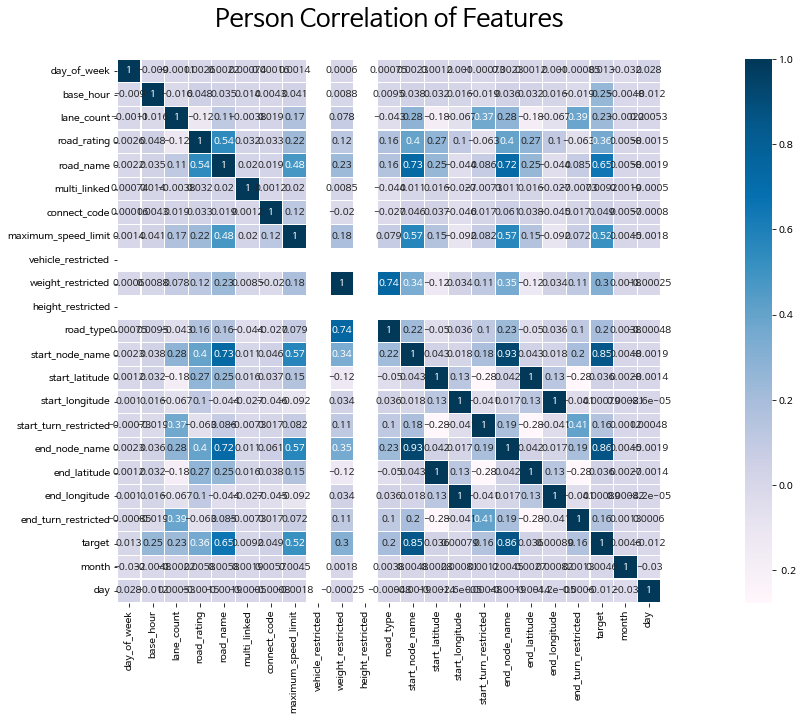

In [ ]:
colormap = plt.cm.PuBu
plt.figure(figsize=(30, 10))
plt.title("Person Correlation of Features", y = 1.05, size = 25)
sns.heatmap(df_train.drop(['id','base_date'],axis=1).astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 10})

## 2. 날짜 배치

날짜 배치의 경우는 변수로 사용하려기 보다는 train과 validation을 나누기 위해 날짜순으로 배치한다.

현재 구해야 하는 target은 8월이다. 그래서 7월을 validation 데이터로 사용하려 한다. (sequential한 특징이 있을 것이라는 전제로 나눈것)

(시각화의 경우 편의를 위해 인코딩을 하지않음)

In [ ]:
df_train=pd.read_parquet('/content/drive/MyDrive/jeju_traffic/train.parquet')


df_train=df_train.sort_values(by=['base_date']) #날짜 순서대로 배치

#시간에 따라 validation 생성 (우리가 예측하는 데이터는 8월 데이터이므로 7월 데이터들을 validation으로 채택)
df_validation=df_train[df_train['base_date']>20220700]
df_train=df_train[df_train['base_date']<20220700]

# Train 데이터 시각화

여러가지 변수들의 target과의 관계를 우선 살펴보도록 하자

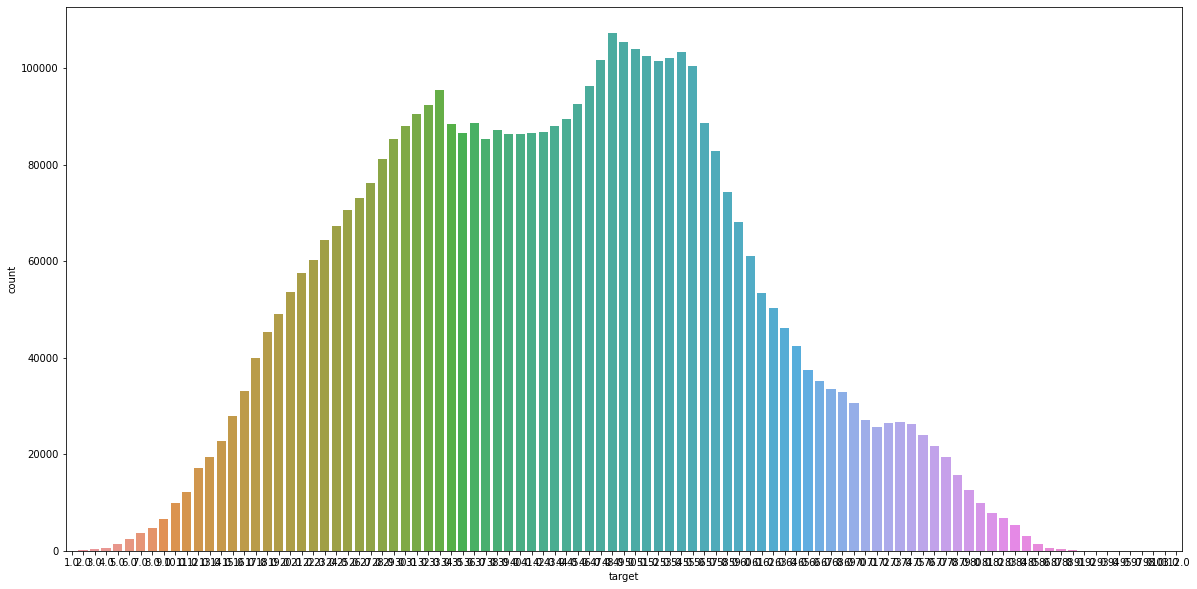

In [ ]:
# 타겟의 분포 //정규 분포와 비슷한 형태를 띄운다.

plt.figure(figsize=(20,10))
sns.countplot(x="target",data=df_train)
plt.show()

In [ ]:
df_train.columns

Index(['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted', 'target'],
      dtype='object')

In [ ]:
df_train['maximum_speed_limit'].unique()

array([70., 50., 80., 60., 30., 40.])

In [ ]:
# 월별 타겟의 평균값 평균값으로 보았을때는 큰 의미는 없어보임  -> 월별 분포를 볼까

x=[]
y=[]

for i,j in zip(df_train.groupby('day_of_week').mean()['target'].index,df_train.groupby('day_of_week').mean()['target']):
  print(i,'               ',j)
  x.append(i)
  y.append(j)


plt.figure(figsize=(30,10))
sns.barplot(x=x,y=y)
plt.show()

plt.figure(figsize=(30,10))
sns.barplot(x=x,y=np.array(y)-40)
plt.show()

In [ ]:
#7일 모두 분포에대해서도 큰 두드러지는 특징은 없는것 같다.. // 시속 80이상의 이상치는 제거해도 괜찮으려나? decision tree모델들은 큰 영향을 받지 않는다고 하는데 다른 regression모델을 사용할때는 제거해서 사용해봐야겠다.
#  // 실제 maximum_speed_limit 의경우 70,50,80,60,30,40이다.

for i in df_train['day_of_week'].unique():
  print(i)
  plt.figure(figsize=(20,10))
  sns.countplot(x="target",data=df_train[df_train['day_of_week']==i],)
  # plt.xlabel(i)
  plt.show()

In [ ]:
list(df_train.columns)

['id',
 'base_date',
 'day_of_week',
 'base_hour',
 'lane_count',
 'road_rating',
 'road_name',
 'multi_linked',
 'connect_code',
 'maximum_speed_limit',
 'vehicle_restricted',
 'weight_restricted',
 'height_restricted',
 'road_type',
 'start_node_name',
 'start_latitude',
 'start_longitude',
 'start_turn_restricted',
 'end_node_name',
 'end_latitude',
 'end_longitude',
 'end_turn_restricted',
 'target']

base_hour


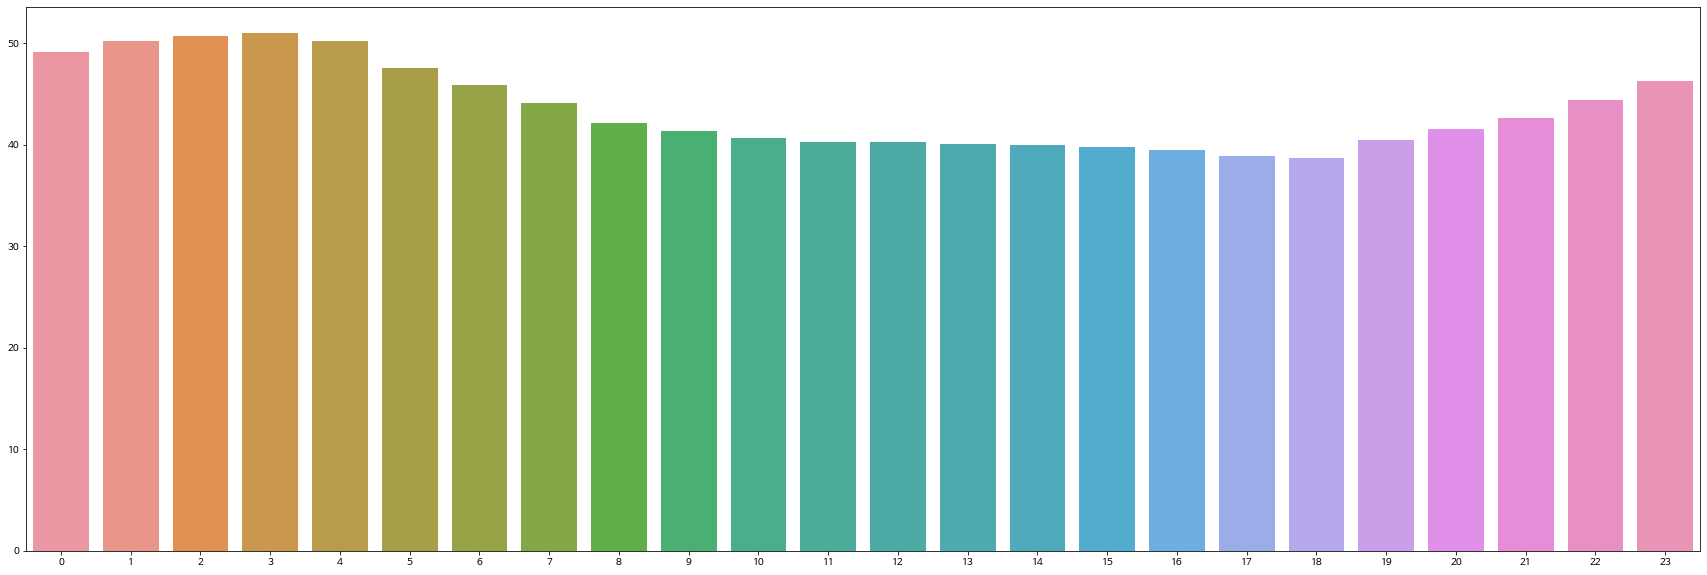

lane_count


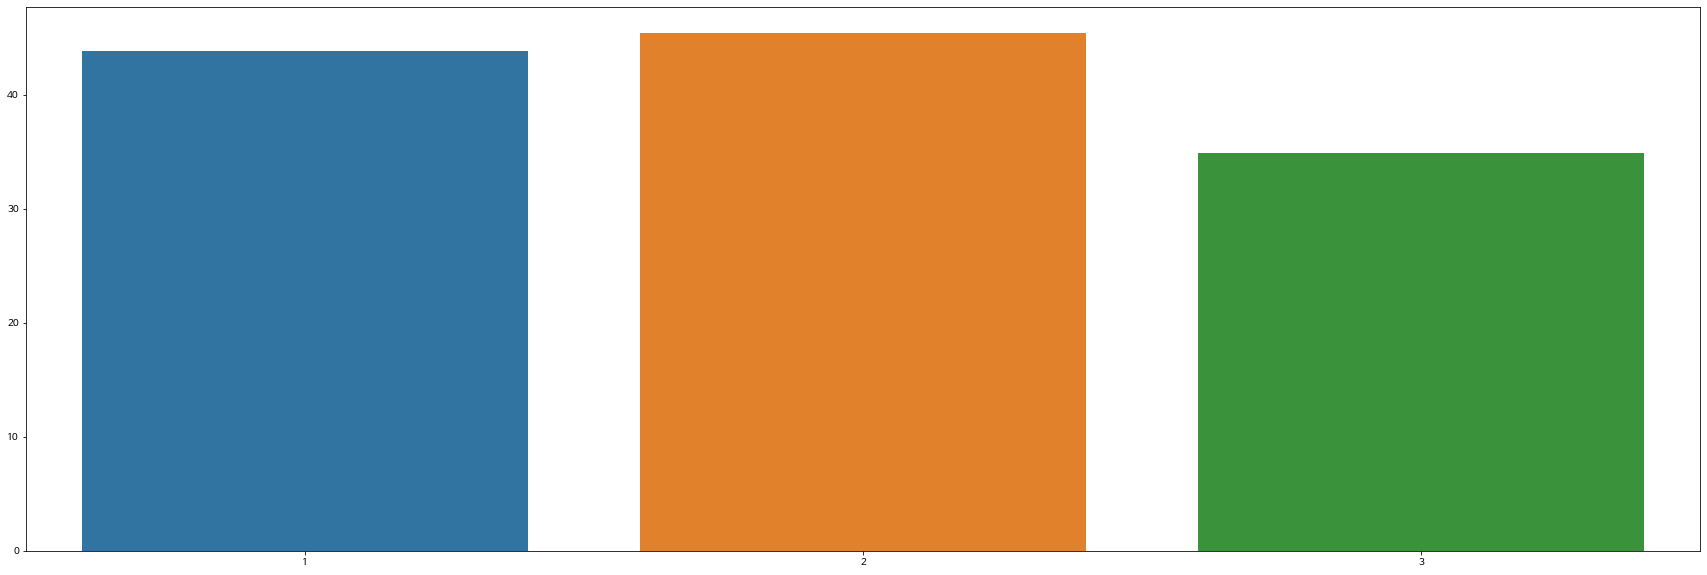

road_rating


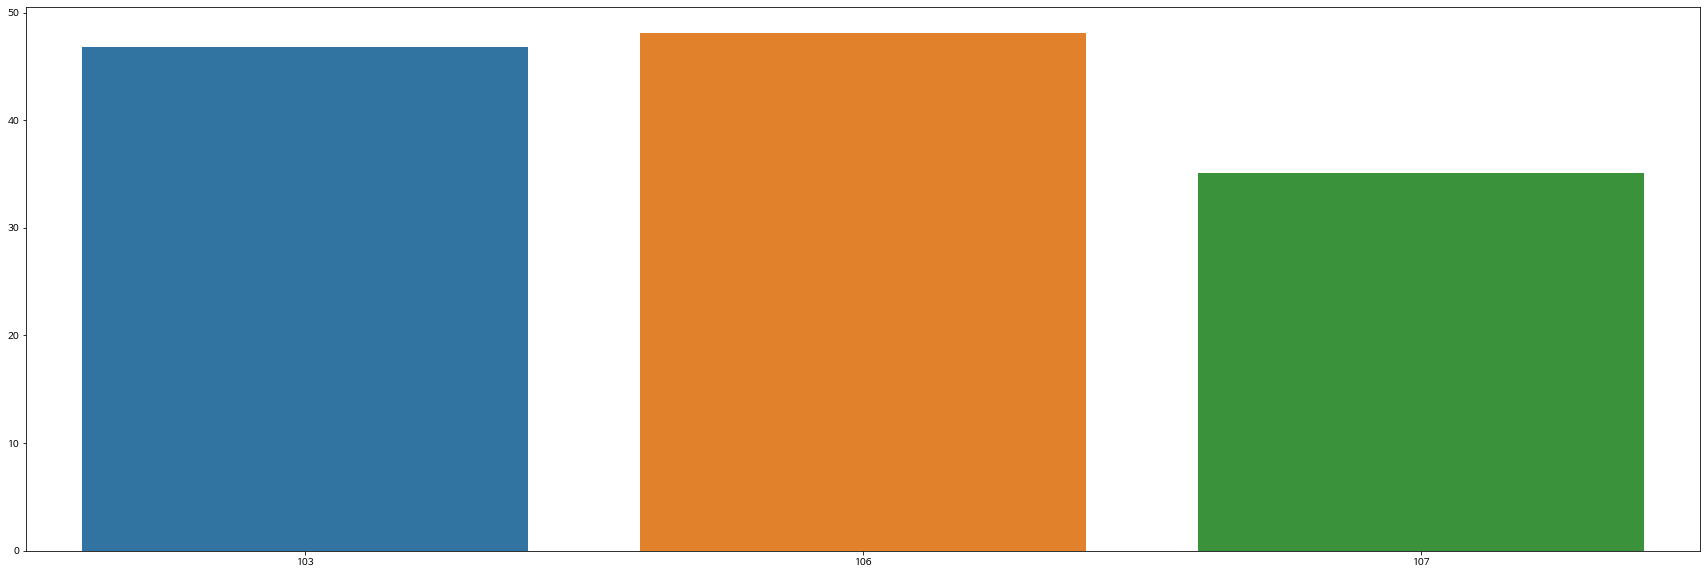

road_name


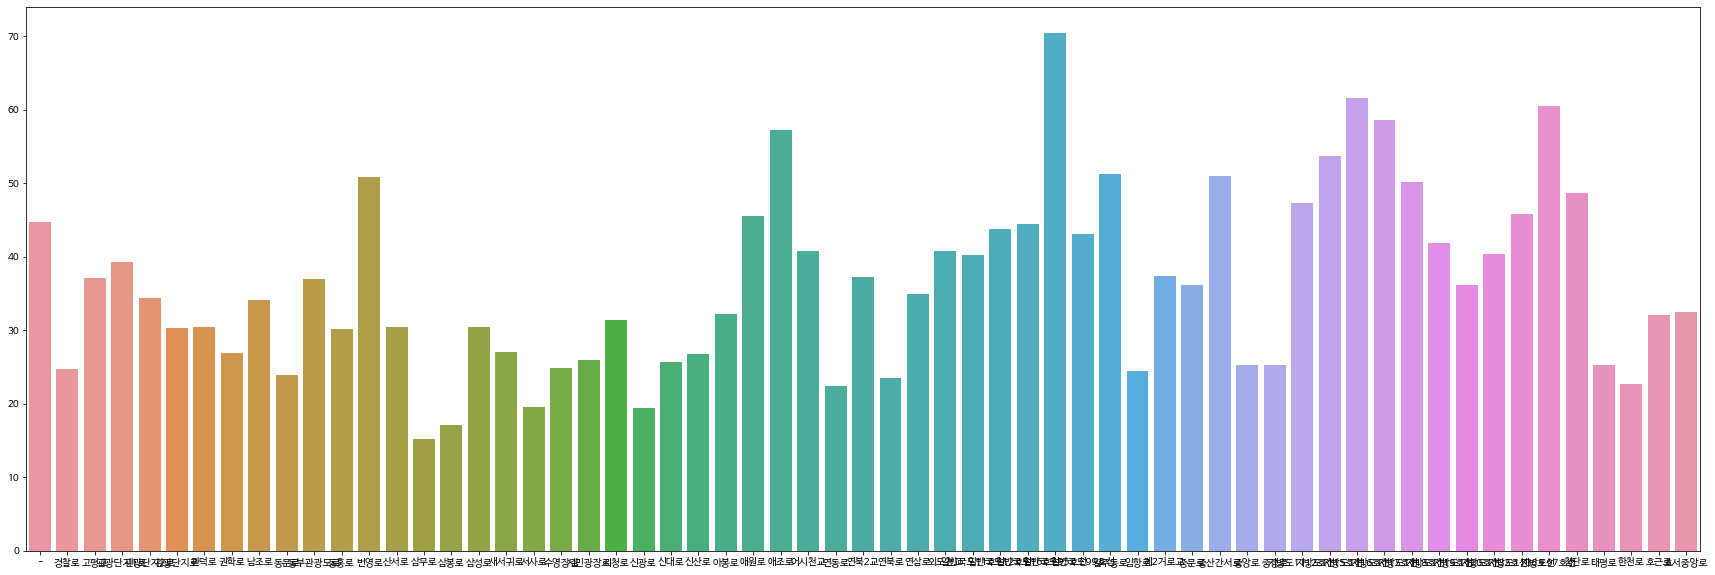

multi_linked


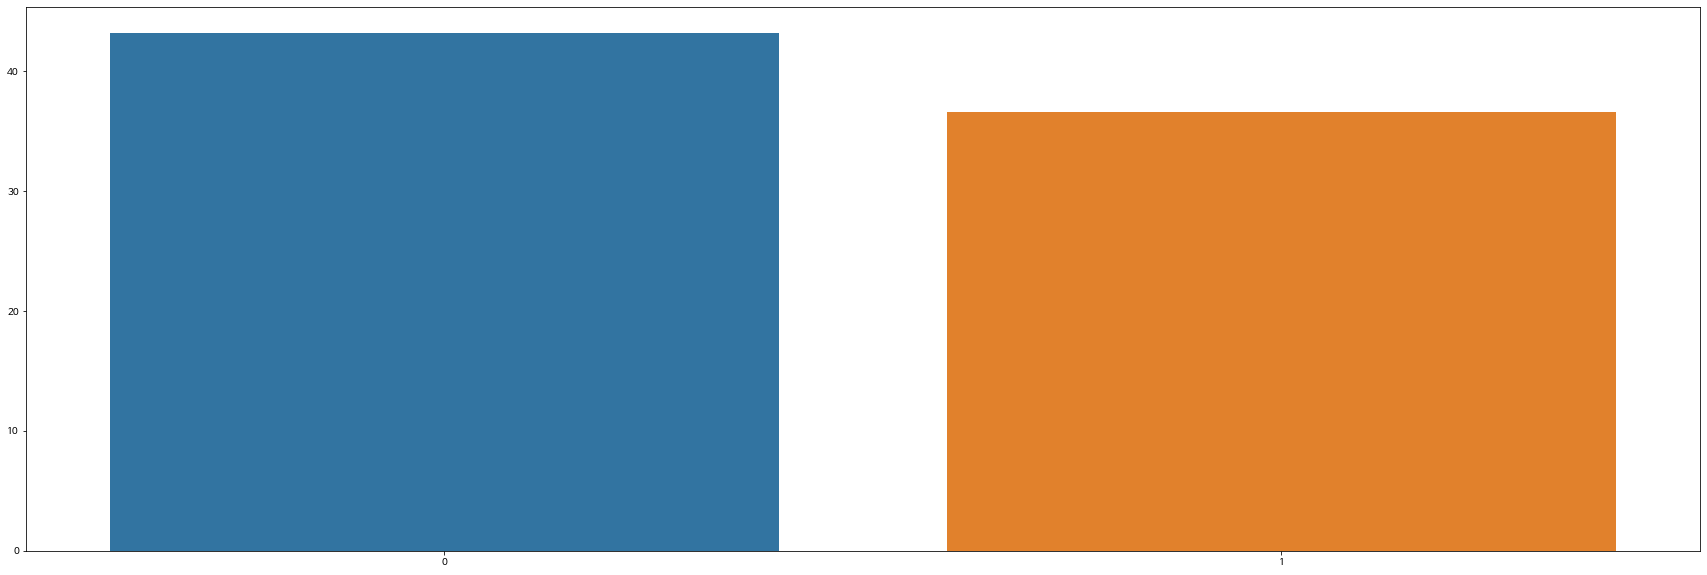

connect_code


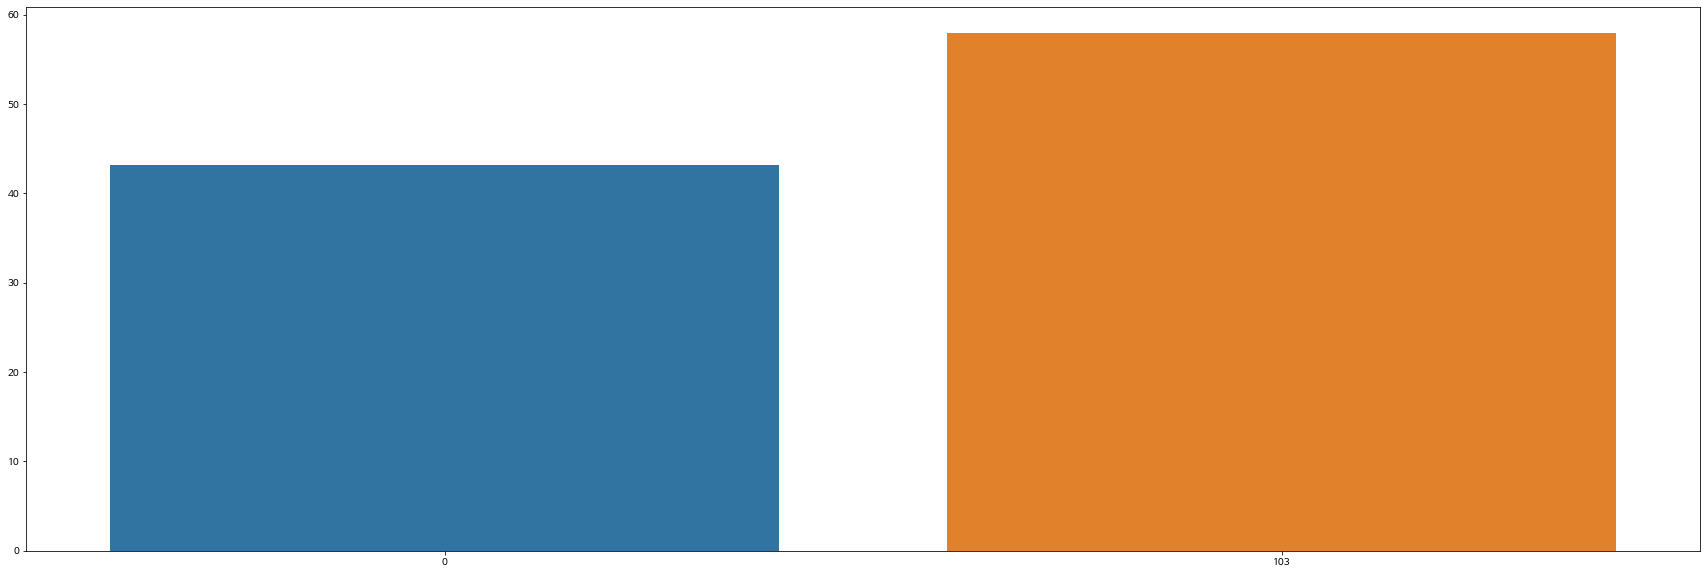

maximum_speed_limit


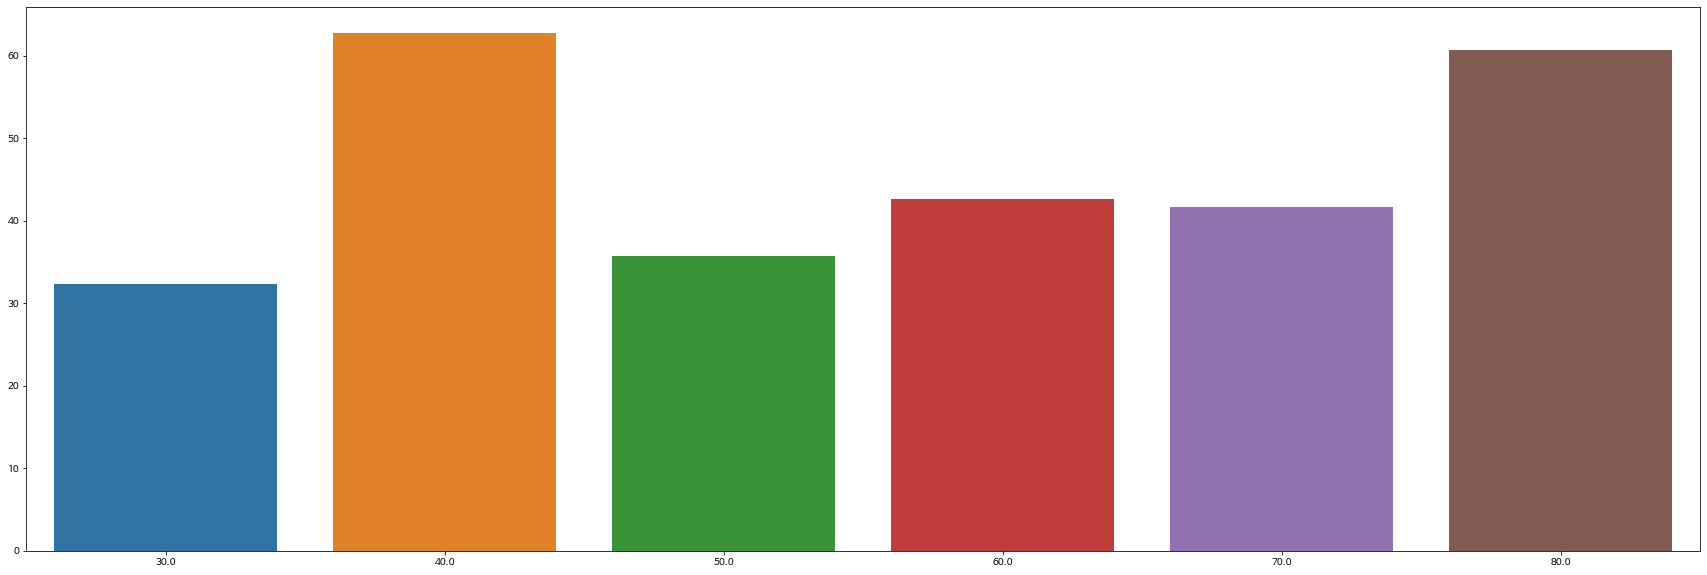

vehicle_restricted


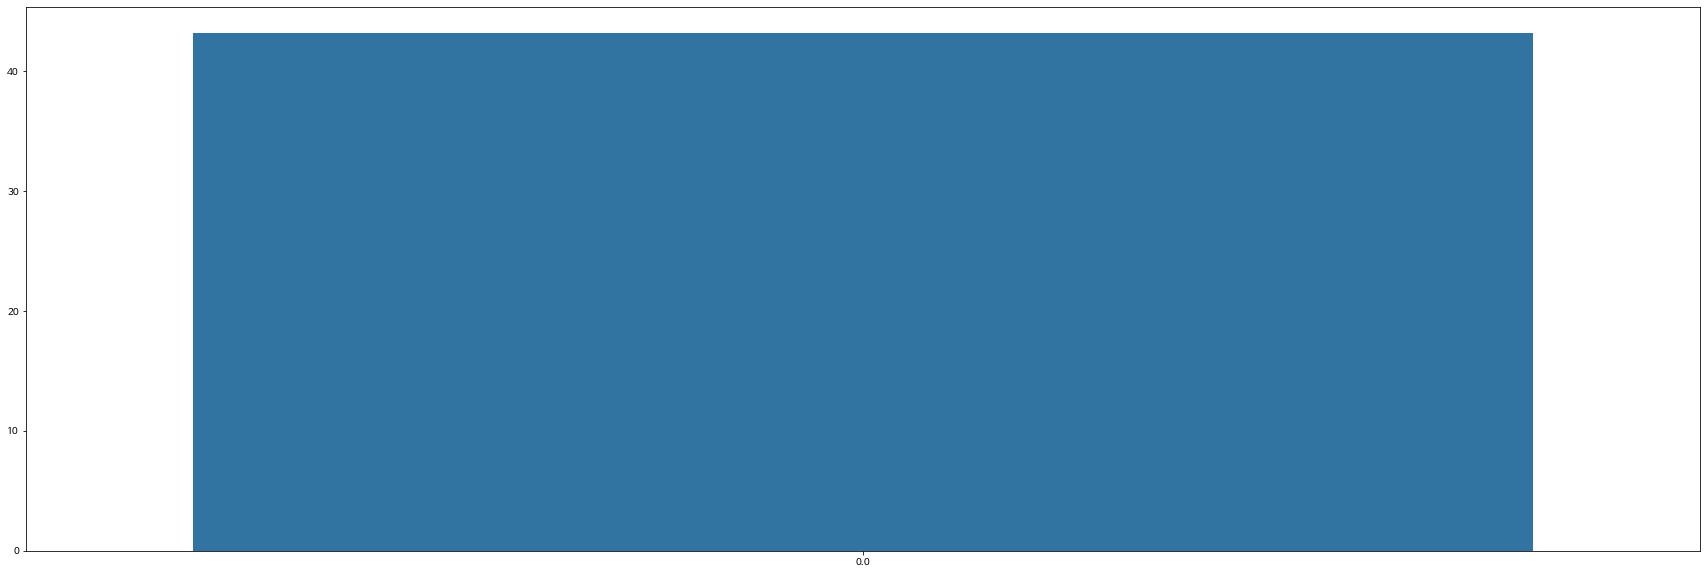

weight_restricted


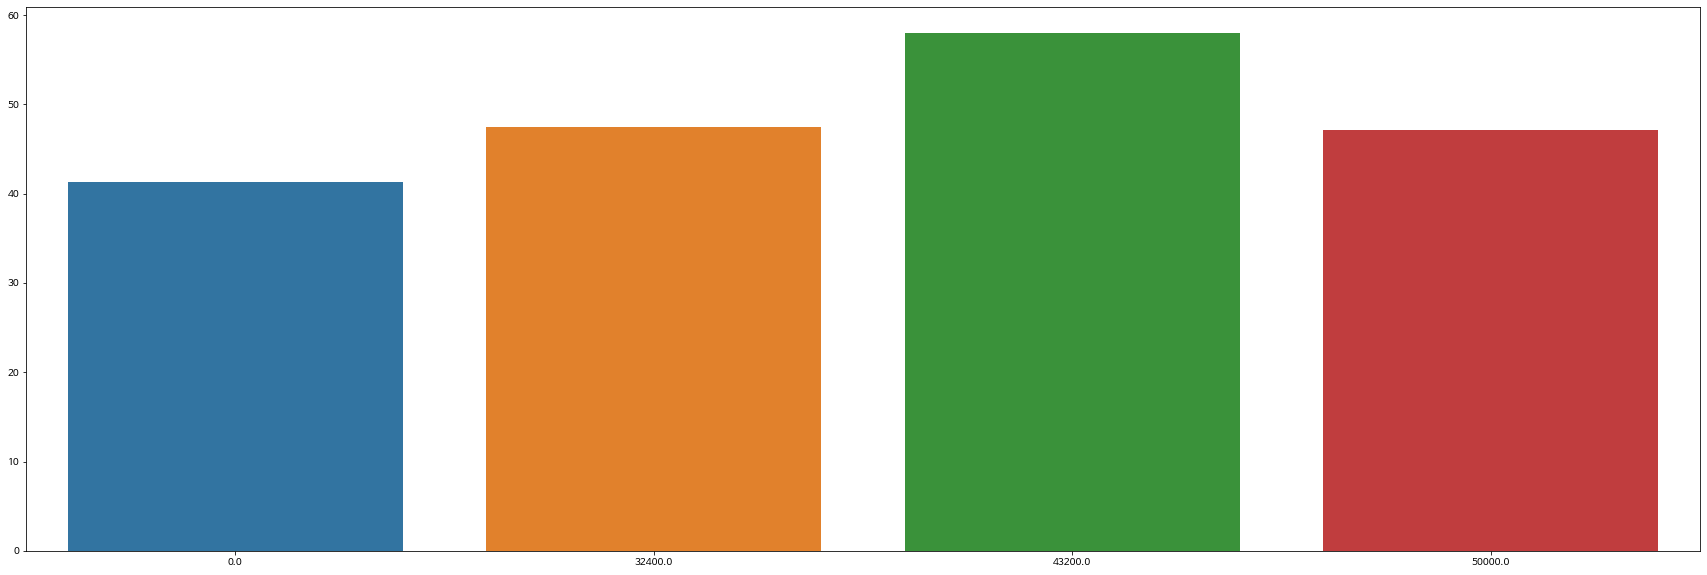

height_restricted


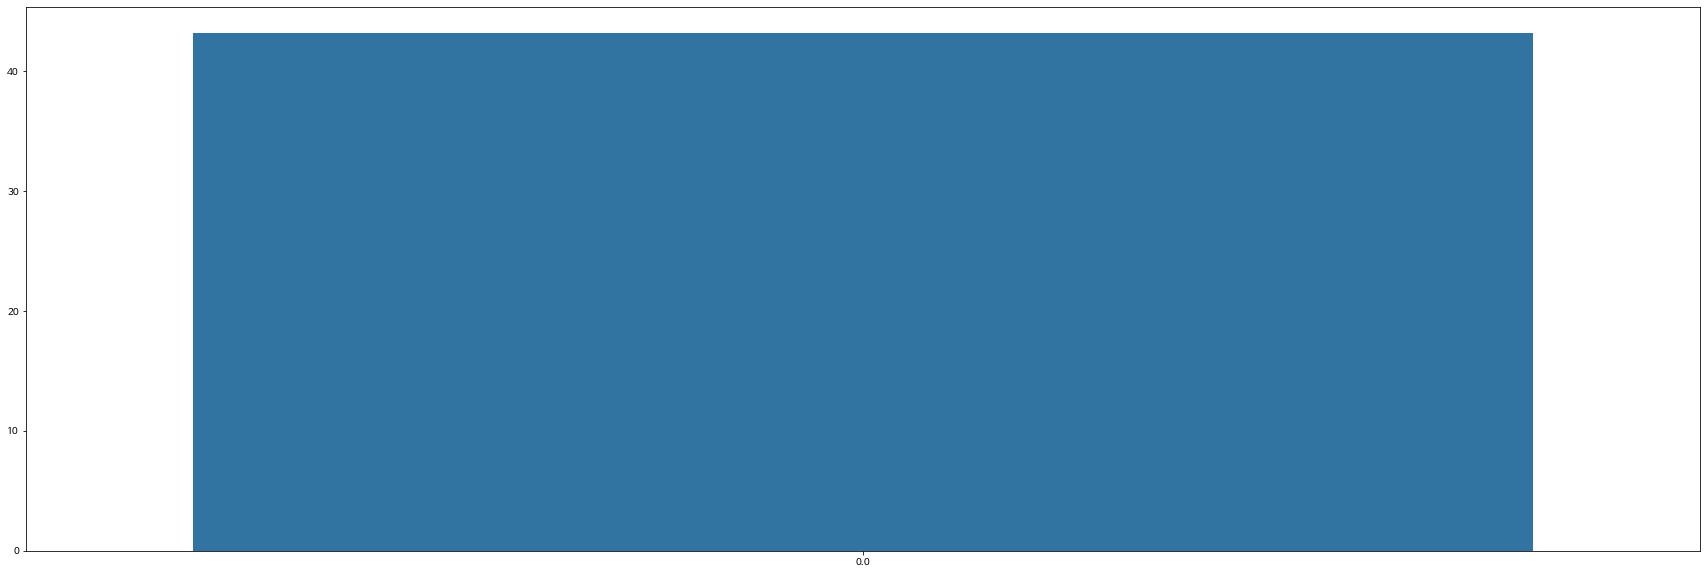

road_type


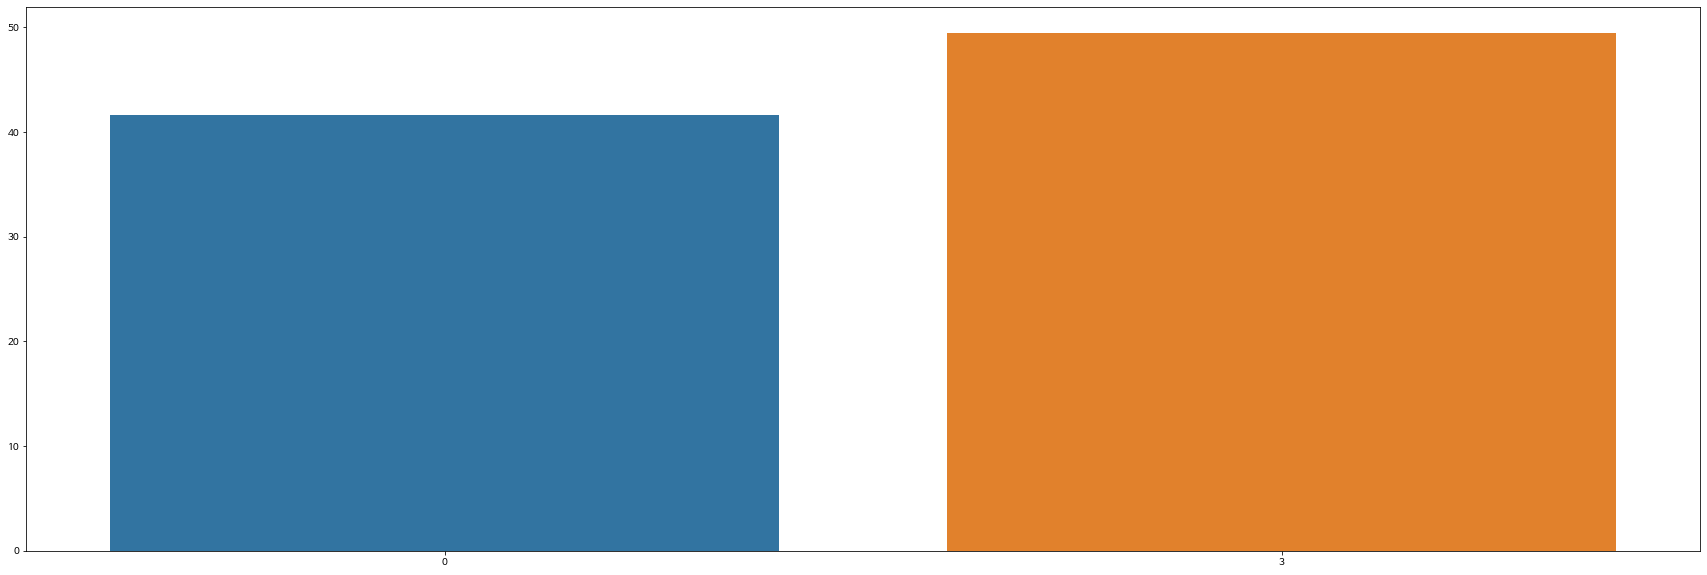

start_node_name


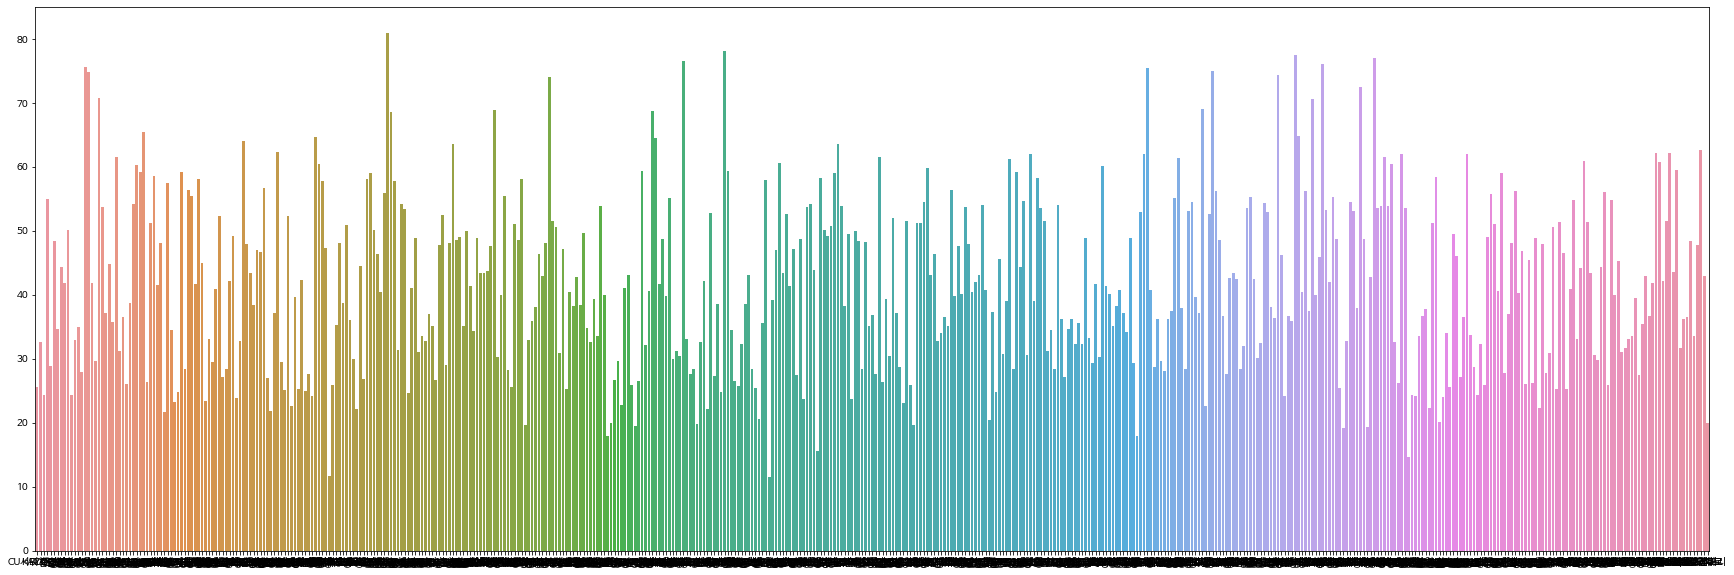

start_latitude


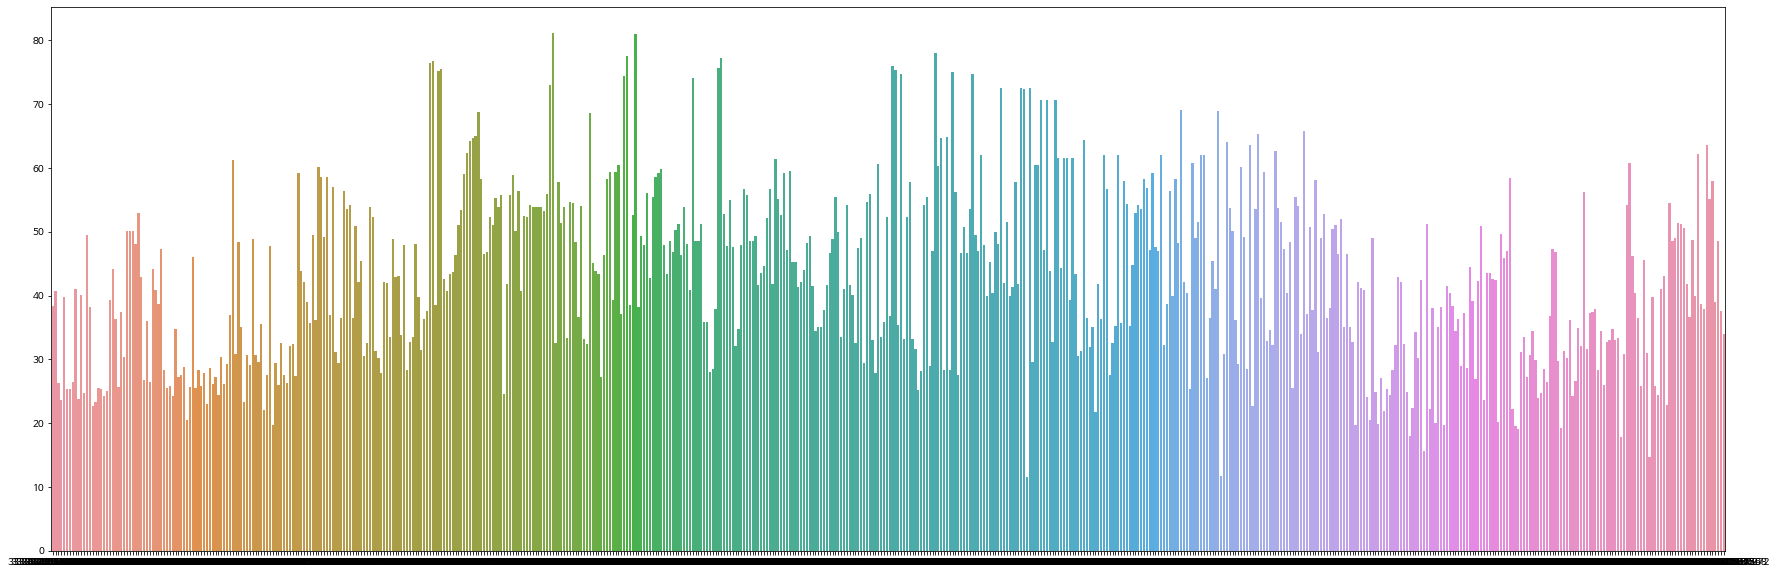

start_longitude


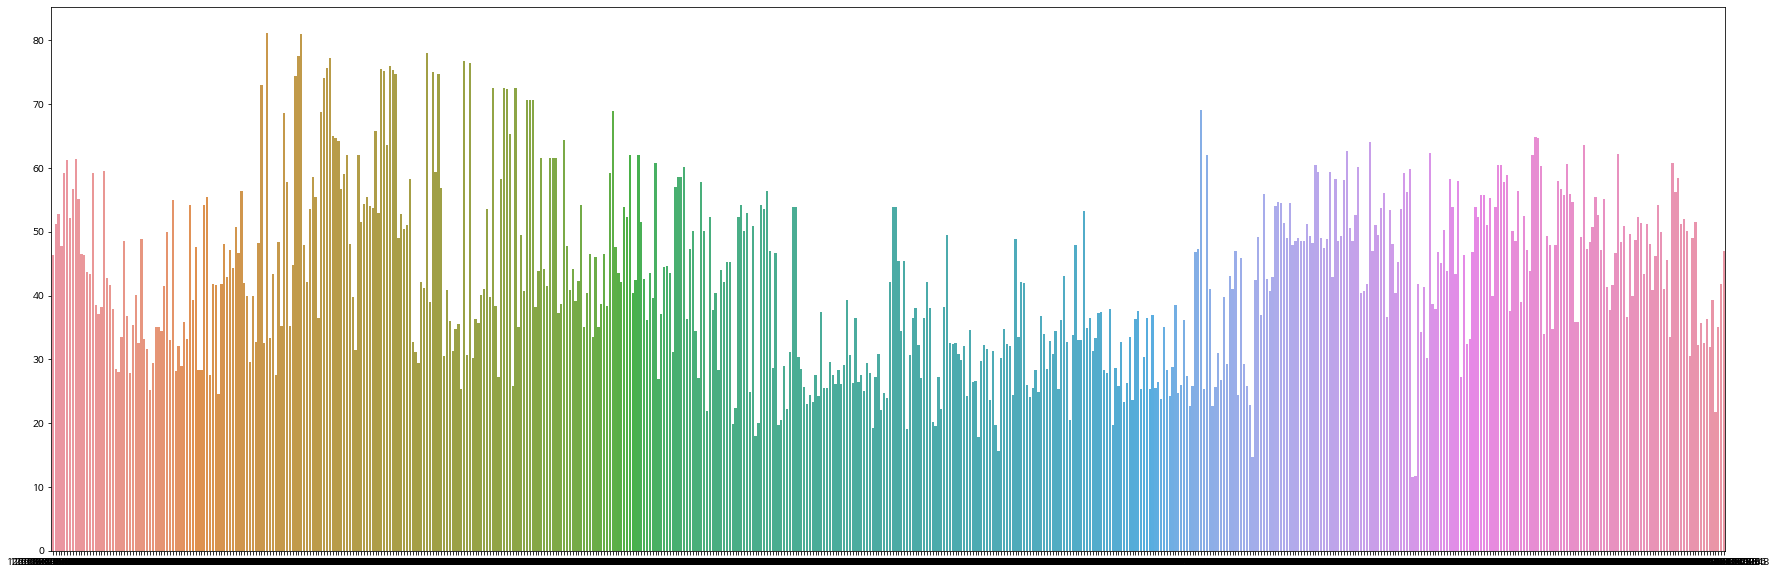

start_turn_restricted


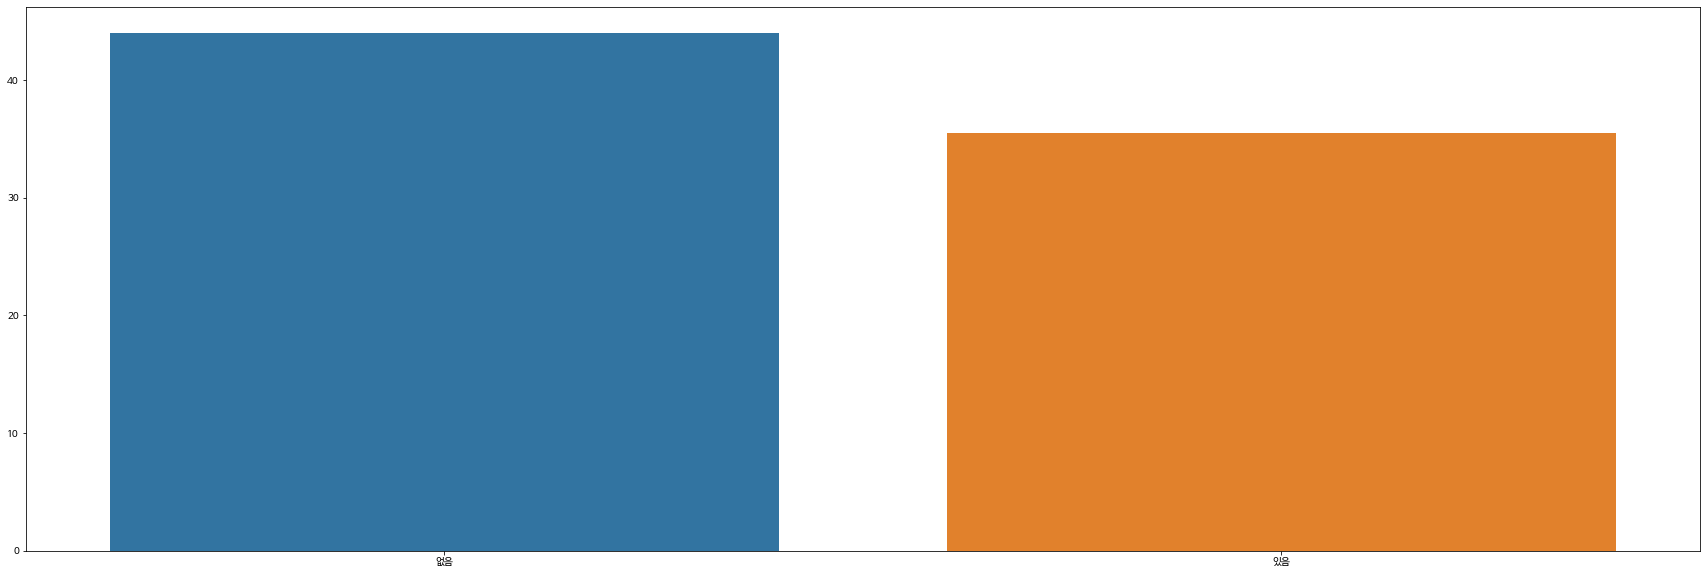

end_node_name


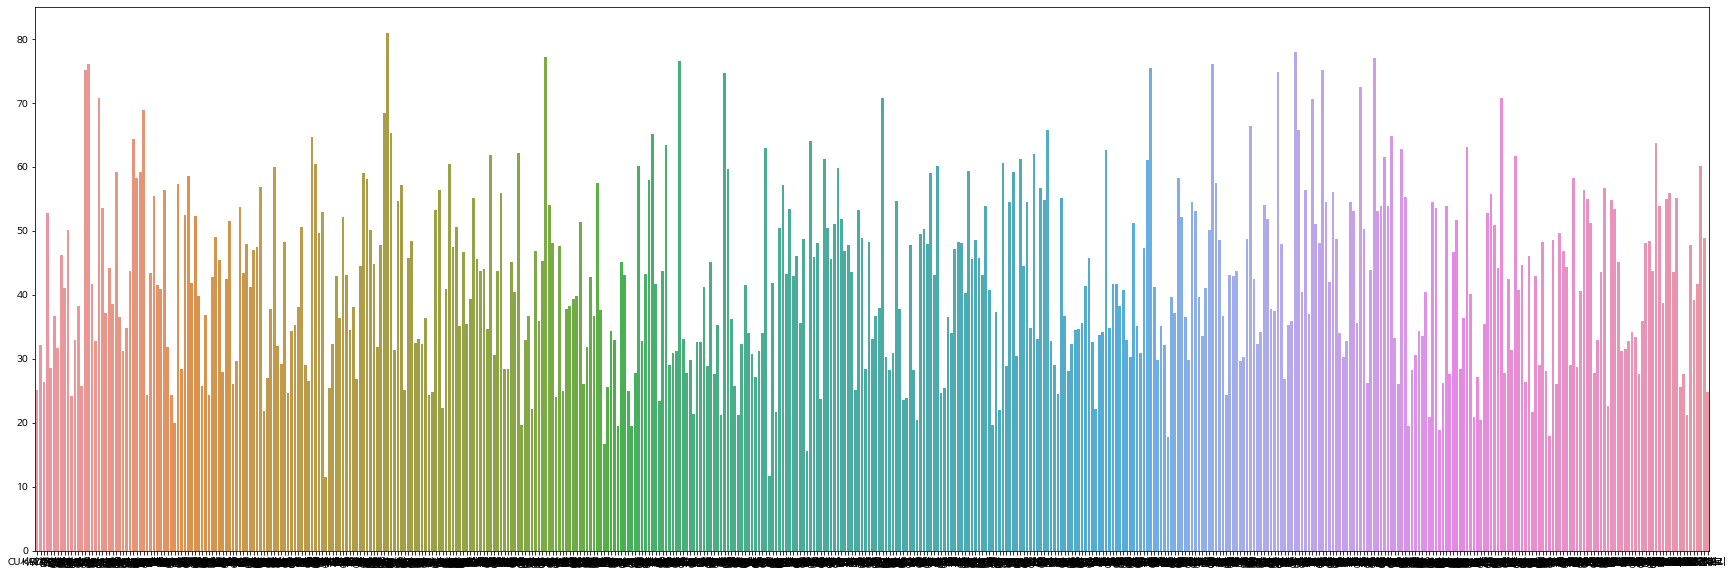

end_latitude


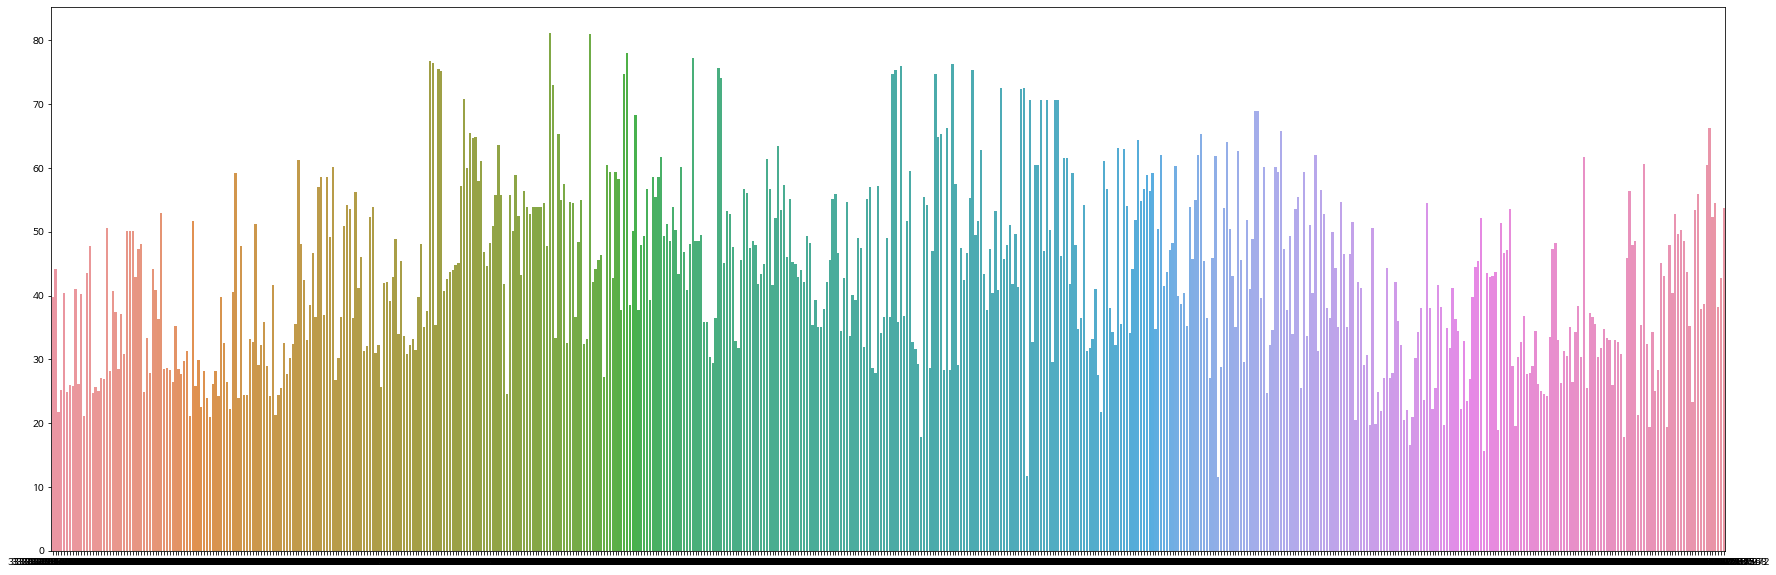

end_longitude


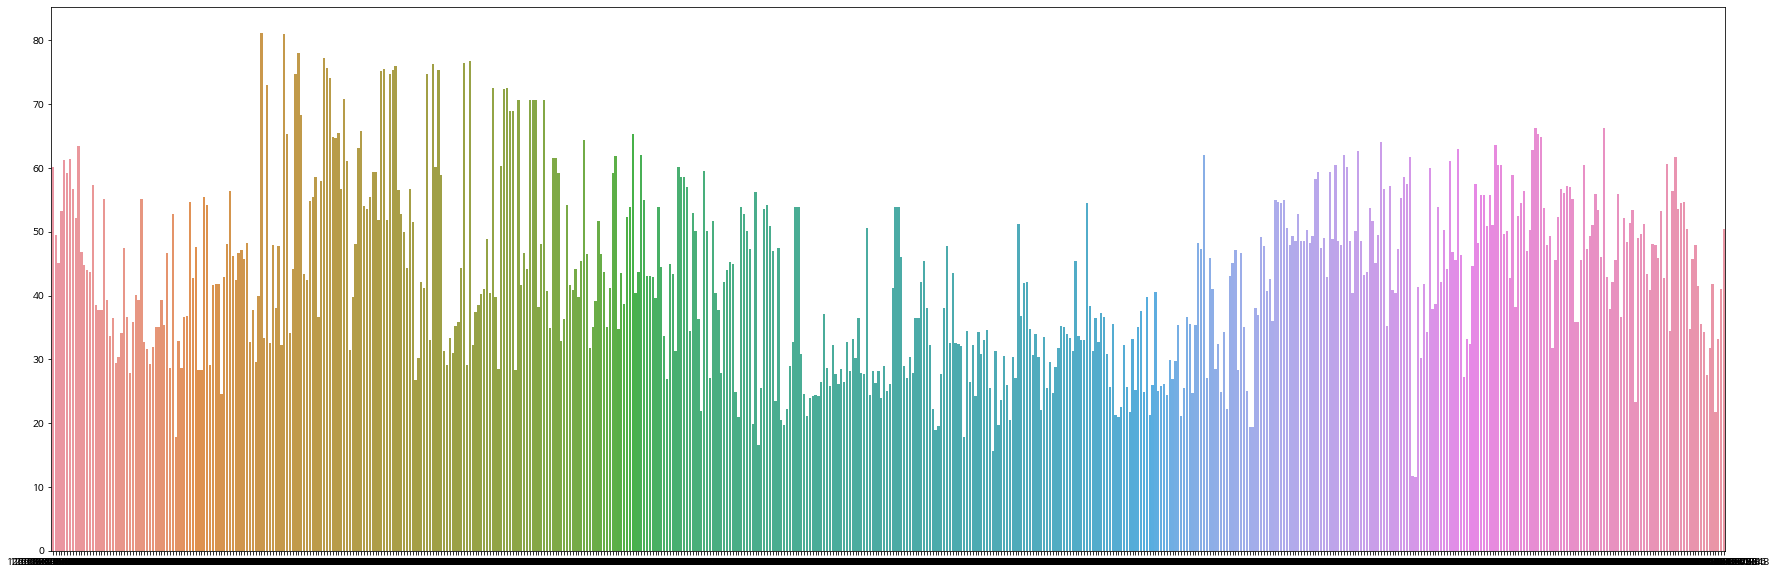

end_turn_restricted


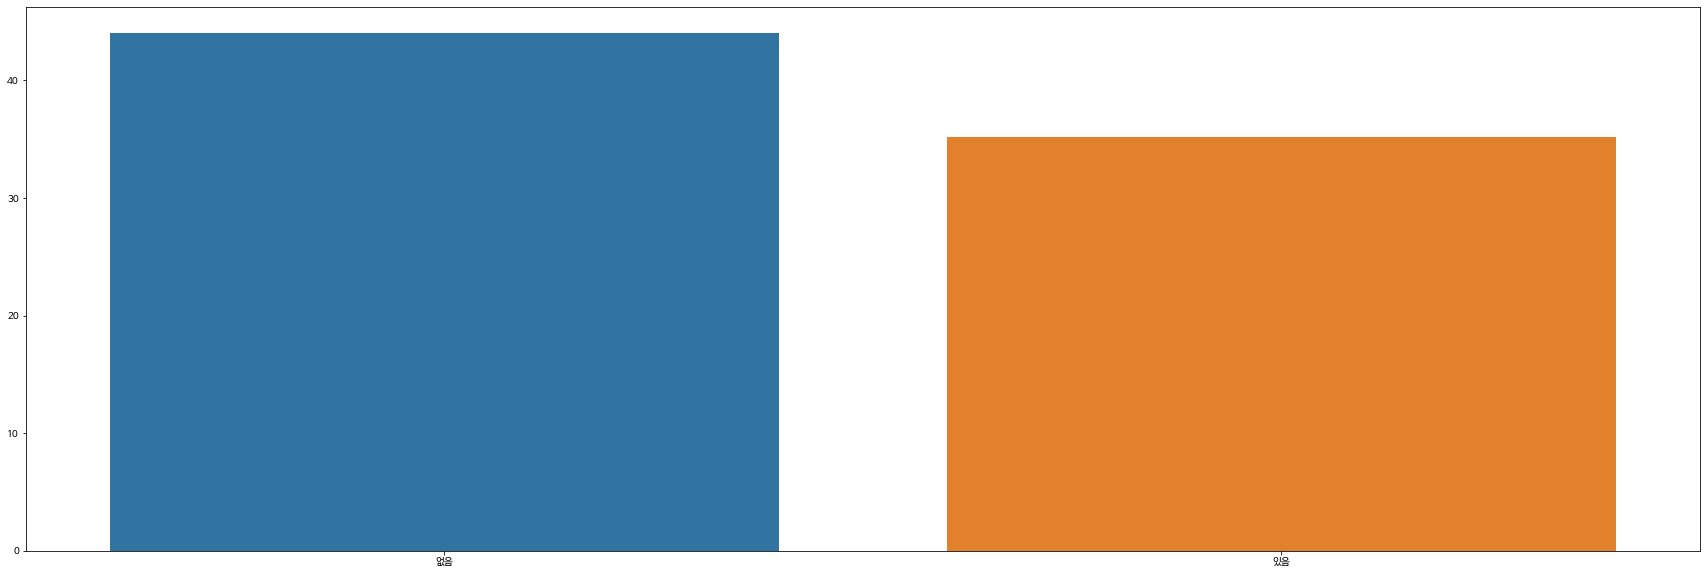

In [ ]:
#다른 컬럼에 대해서도 범주당 평균을 봐보도록 하자.
delete_name_list=['id','base_date','day_of_week','target']
dd=list(df_train.columns)
for delete_name in delete_name_list:
  dd.remove(delete_name)

for column_name in dd:
  x=[]
  y=[]

  for i,j in zip(df_train.groupby(column_name).mean()['target'].index,df_train.groupby(column_name).mean()['target']):
    # print(i,'               ',j)
    x.append(i)
    y.append(j)


  plt.figure(figsize=(30,10))
  print(column_name)
  sns.barplot(x=x,y=y)
  plt.show()

#  'base_hour', 아침,새벽시간과 낮시간의 차이가 확연히 보인다. 이를 구별하는 column을 생성하는것도 의미가 있을듯 하다.
#  'lane_count', 차선이 많을수록 당연히 속도가 높을것이라 생각했지만 아닌걸 보면 안에 분포를 분석해봐도 좋을듯 하다.
#  'road_rating', 103 - 일반 국도, 106 - 지방도, 107 - 시군도
#  'road_name',  : 도로별 평균 차이가 꽤 심한것을 볼수있다. 중요한 요소가 될것 같다.
#  'multi_linked', 중용구간 여부 : 2개 이상의 노선이 도로의 일정 구간을 공동으로 사용하는 구간을 중용구간이라고한다.
#  'connect_code', 103 - 속성 변화점 : 교통통제점, 도로운영 변환점
#  'maximum_speed_limit',: 속도 제한에따라 맞게 평균이 올라갈것이라 예상했지만 40이 갑작스럽게 올라가는 모습이 보임 분포와 표본의 수를 살펴보아야 할것 같다.
#  'vehicle_restricted', : 의미 X
#  'weight_restricted', : 의미를 못찾을것 같음
#  'height_restricted', : 의미 X
#  'road_type', :0 과 3이 어떤 의미가 있는지는 모르겠음
#  'start_node_name', : 장소이름, start_node_name(('start_latitude','start_longitude'),'start_turn_restricted')
#  'start_latitude', 
#  'start_longitude',
#  'start_turn_restricted',
#  'end_node_name',: start노드와 비슷함
#  'end_latitude',
#  'end_longitude',
#  'end_turn_restricted',

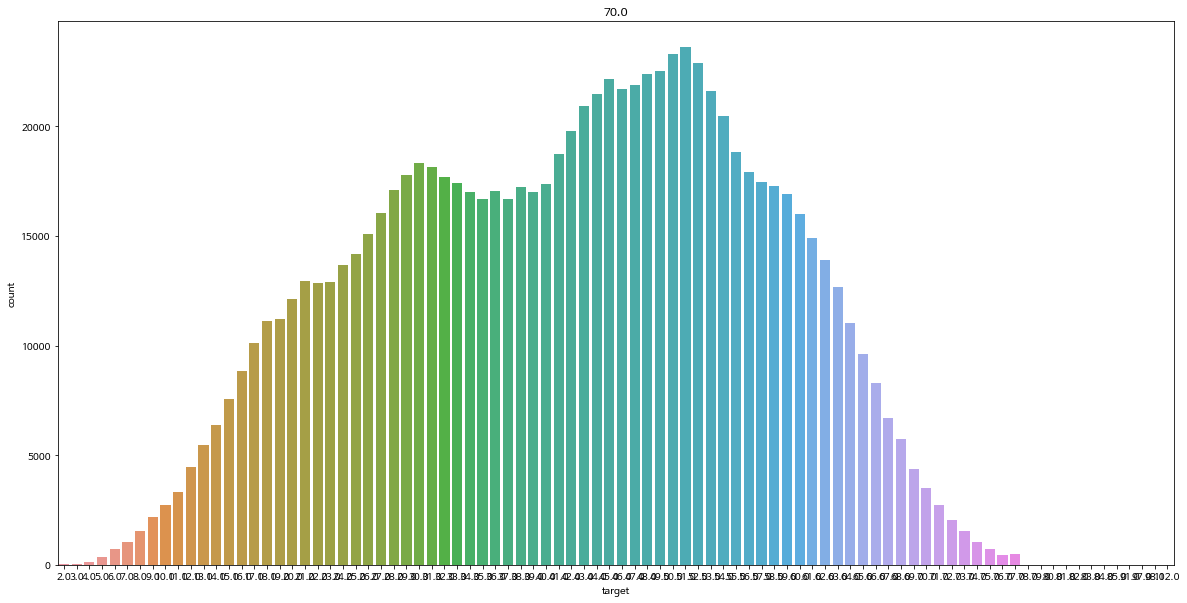

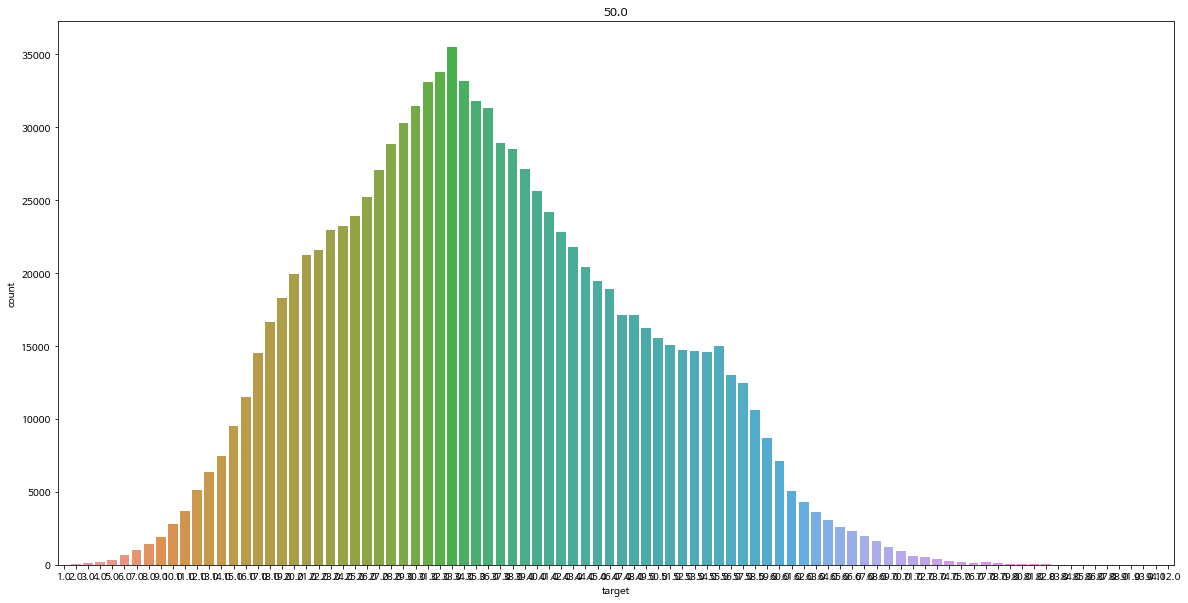

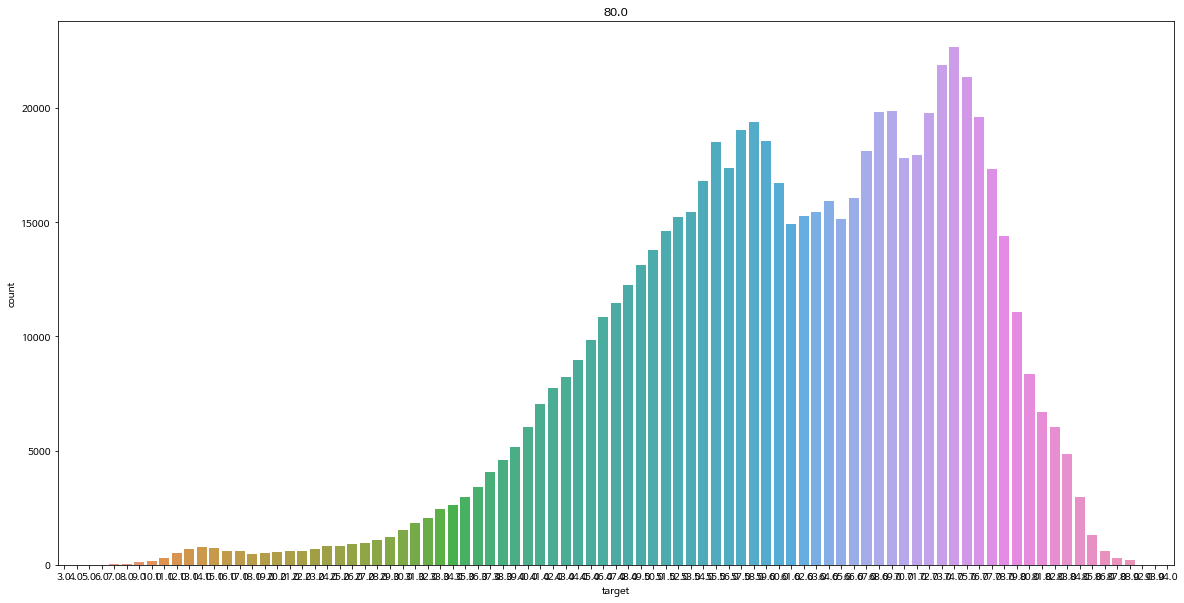

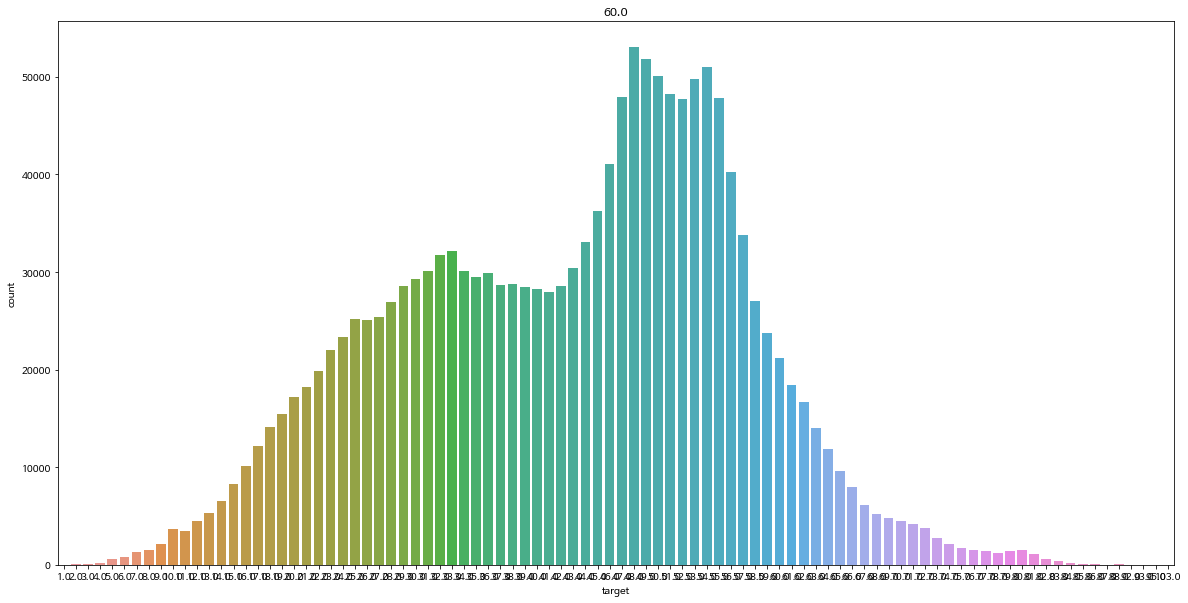

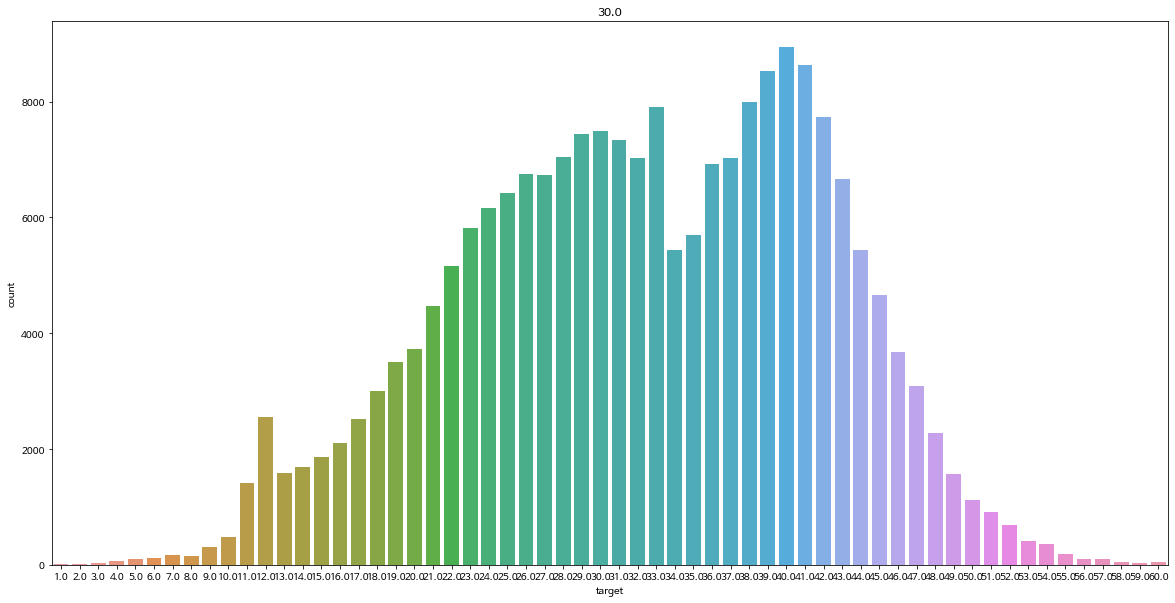

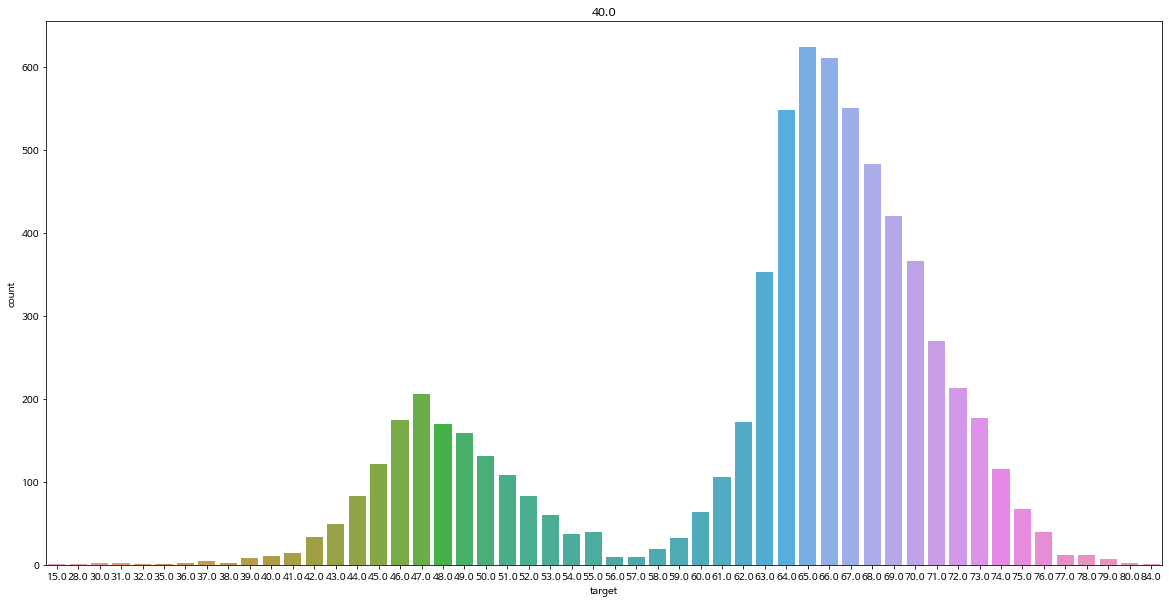

In [ ]:
#값과 target분포의 평균과 비슷한것을 볼수있다. (평균이 maximum_speed_limit에 가깝다.) // 대부분 분포또한 정규분포와 비슷하지만 40의 경우 많이 특이한 분포를띈다. 저 위치들에대해 조사해볼 필요가 있을듯하다. +시간대 // 새벽이라 단속을 안해서 그런가?
#  속도 제한을 무시하는 경우가 꽤 많다. 이를 함부로 제거해서는 안될것 같다.

for i in df_train['maximum_speed_limit'].unique():
  
  plt.figure(figsize=(20,10))
  sns.countplot(x="target",data=df_train[df_train['maximum_speed_limit']==i],)
  plt.title(i)
  plt.show()

In [ ]:
df_train['road_name'].unique()

array(['지방도1132호선', '일반국도16호선', '일반국도12호선', '-', '일반국도11호선', '지방도1115호선',
       '번영로', '산서로', '중산간서로', '중앙로', '한천로', '중문로', '지방도1112호선', '새서귀로',
       '지방도1118호선', '연북로', '일반국도95호선', '애원로', '경찰로', '지방도1119호선',
       '지방도1120호선', '일주동로', '시청로', '서사로', '일반국도99호선', '연삼로', '신광로',
       '지방도97호선', '임항로', '아봉로', '연동로', '동홍로', '태평로', '외도천교', '관덕로',
       '제2거로교', '삼성로', '동부관광도로', '수영장길', '남조로', '중정로', '고평교', '권학로',
       '어시천교', '지방도1136호선', '동문로', '삼봉로', '애조로', '관광단지1로', '시민광장로',
       '관광단지로', '삼무로', '지방도1116호선', '신산로', '연북2교', '신대로', '지방도1117호선',
       '관광단지2로', '호서중앙로', '호근로', '첨단로'], dtype=object)

지방도1132호선


<Figure size 1440x720 with 0 Axes>

일반국도16호선


<Figure size 1440x720 with 0 Axes>

일반국도12호선


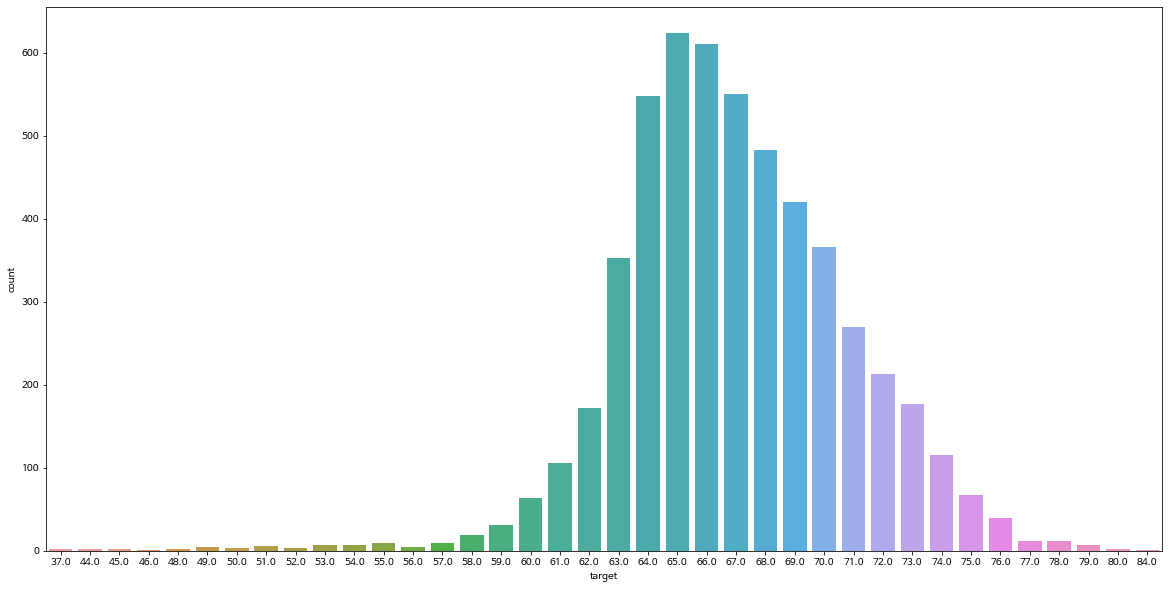

-


<Figure size 1440x720 with 0 Axes>

일반국도11호선


<Figure size 1440x720 with 0 Axes>

지방도1115호선


<Figure size 1440x720 with 0 Axes>

번영로


<Figure size 1440x720 with 0 Axes>

산서로


<Figure size 1440x720 with 0 Axes>

중산간서로


<Figure size 1440x720 with 0 Axes>

중앙로


<Figure size 1440x720 with 0 Axes>

한천로


<Figure size 1440x720 with 0 Axes>

중문로


<Figure size 1440x720 with 0 Axes>

지방도1112호선


<Figure size 1440x720 with 0 Axes>

새서귀로


<Figure size 1440x720 with 0 Axes>

지방도1118호선


<Figure size 1440x720 with 0 Axes>

연북로


<Figure size 1440x720 with 0 Axes>

일반국도95호선


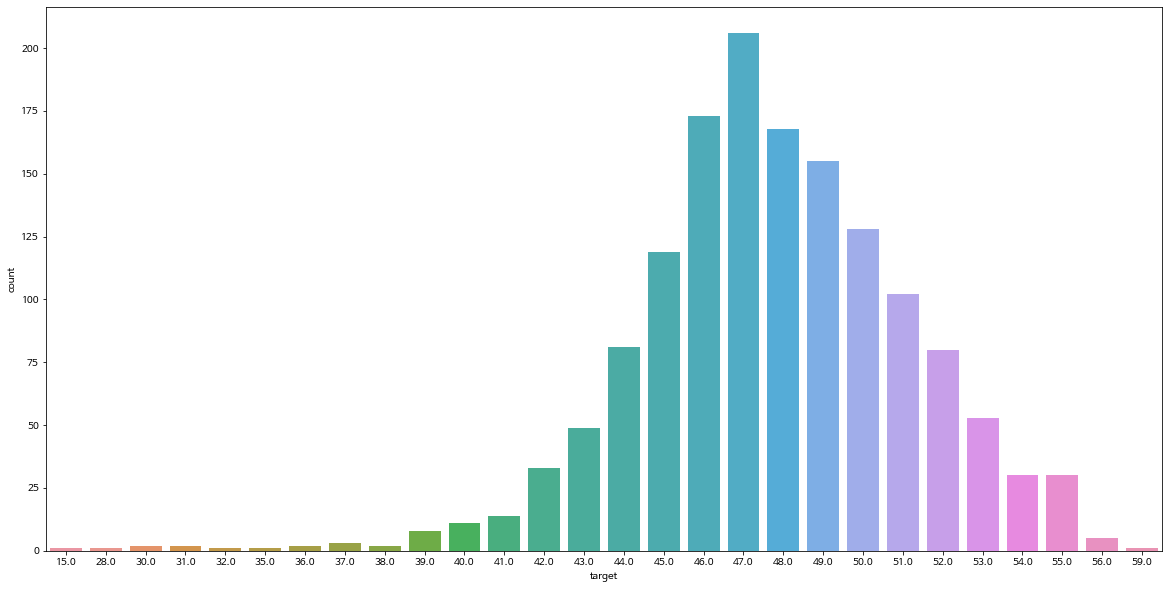

애원로


<Figure size 1440x720 with 0 Axes>

경찰로


<Figure size 1440x720 with 0 Axes>

지방도1119호선


<Figure size 1440x720 with 0 Axes>

지방도1120호선


<Figure size 1440x720 with 0 Axes>

일주동로


<Figure size 1440x720 with 0 Axes>

시청로


<Figure size 1440x720 with 0 Axes>

서사로


<Figure size 1440x720 with 0 Axes>

일반국도99호선


<Figure size 1440x720 with 0 Axes>

연삼로


<Figure size 1440x720 with 0 Axes>

신광로


<Figure size 1440x720 with 0 Axes>

지방도97호선


<Figure size 1440x720 with 0 Axes>

임항로


<Figure size 1440x720 with 0 Axes>

아봉로


<Figure size 1440x720 with 0 Axes>

연동로


<Figure size 1440x720 with 0 Axes>

동홍로


<Figure size 1440x720 with 0 Axes>

태평로


<Figure size 1440x720 with 0 Axes>

외도천교


<Figure size 1440x720 with 0 Axes>

관덕로


<Figure size 1440x720 with 0 Axes>

제2거로교


<Figure size 1440x720 with 0 Axes>

삼성로


<Figure size 1440x720 with 0 Axes>

동부관광도로


<Figure size 1440x720 with 0 Axes>

수영장길


<Figure size 1440x720 with 0 Axes>

남조로


<Figure size 1440x720 with 0 Axes>

중정로


<Figure size 1440x720 with 0 Axes>

고평교


<Figure size 1440x720 with 0 Axes>

권학로


<Figure size 1440x720 with 0 Axes>

어시천교


<Figure size 1440x720 with 0 Axes>

지방도1136호선


<Figure size 1440x720 with 0 Axes>

동문로


<Figure size 1440x720 with 0 Axes>

삼봉로


<Figure size 1440x720 with 0 Axes>

애조로


<Figure size 1440x720 with 0 Axes>

관광단지1로


<Figure size 1440x720 with 0 Axes>

시민광장로


<Figure size 1440x720 with 0 Axes>

관광단지로


<Figure size 1440x720 with 0 Axes>

삼무로


<Figure size 1440x720 with 0 Axes>

지방도1116호선


<Figure size 1440x720 with 0 Axes>

신산로


<Figure size 1440x720 with 0 Axes>

연북2교


<Figure size 1440x720 with 0 Axes>

신대로


<Figure size 1440x720 with 0 Axes>

지방도1117호선


<Figure size 1440x720 with 0 Axes>

관광단지2로


<Figure size 1440x720 with 0 Axes>

호서중앙로


<Figure size 1440x720 with 0 Axes>

호근로


<Figure size 1440x720 with 0 Axes>

첨단로


<Figure size 1440x720 with 0 Axes>

In [ ]:
# 일반국도 12호선, 95호선이 40으로 되어있으나 대부분이 40을 넘어가고 12호선의 경우 압도적인 평균속도를 자랑한다.

for i in df_train['road_name'].unique():
  print(i)
  plt.figure(figsize=(20,10))
  try:
    sns.countplot(x="target",data=df_train[(df_train['maximum_speed_limit']==40) & (df_train['road_name']==i)])
  except:
    pass
  # plt.xlabel(i)
  plt.show()

# 모델 실행 및 튜닝하기

1. Linear Regression
2. Logistic Regression
3. Ridge regression
4. Lasso regression
5. Polynomial regression
6. RF
7. XGboost
8. adaboost

이번에는 흔히들 많이 사용하는 XGB모델과 RF모델을 사용하려 한다. 
나머지 모델들은 시간이 될때 다시 공부해보도록 하려한다.

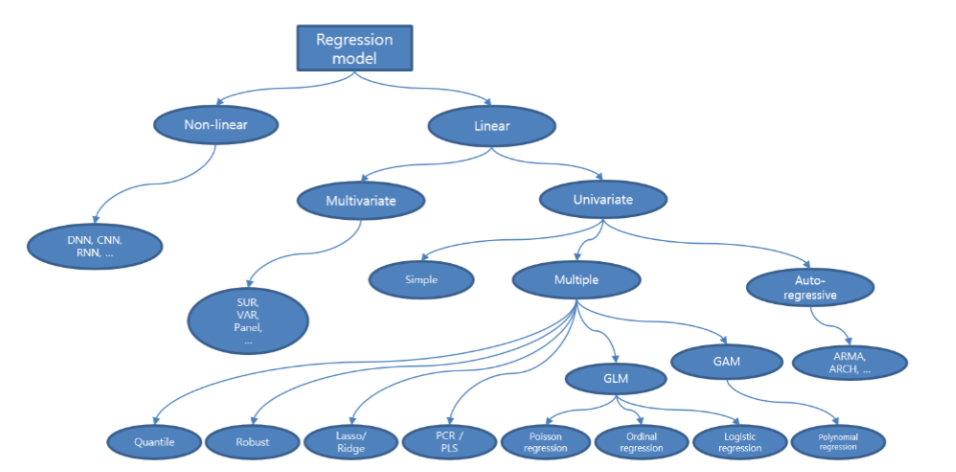


튜닝의 경우는 반복문을 돌리도록 한다. (grid_search 보다 모델 1번 돌리는게 더 빨라서;;;)

## 인코딩 어떻게 할지 선택

### 단순한 1,2,3,4... 인코딩

Decision Tree 모델들을 쓰면 상관 없지만  회귀모델쓸때 사용하면 성능이 굉장히 안좋음 (변수 특성을 입력해주지 못하므로 어찌보면 당연)


In [39]:
df_train=pd.read_parquet('/content/drive/MyDrive/jeju_traffic/train.parquet')

In [40]:
week2int={label:i for i, label in enumerate(df_train['day_of_week'].unique())}
node2int={label:i for i, label in enumerate(set(df_train['start_node_name'].unique()) | set(df_train['end_node_name'].unique()))}
restrict2int={label:i for i, label in enumerate(df_train['end_turn_restricted'].unique())}
road2int ={label:i for i, label in enumerate(df_train['road_name'].unique())}

In [41]:
df_train['month']=df_train['base_date'].apply(lambda x : (x%10000)//100) #월 생성
df_train['day']=df_train['base_date'].apply(lambda x : (x%10000)%100)  #일 생성

df_train['day_of_week']=df_train['day_of_week'].apply(lambda x : week2int[x])
df_train['road_name']=df_train['road_name'].apply(lambda x : road2int[x])
df_train['start_turn_restricted']=df_train['start_turn_restricted'].apply(lambda x : restrict2int[x])
df_train['end_turn_restricted']=df_train['end_turn_restricted'].apply(lambda x : restrict2int[x])
df_train['start_node_name']=df_train['start_node_name'].apply(lambda x : node2int[x])
df_train['end_node_name']=df_train['end_node_name'].apply(lambda x : node2int[x])


In [42]:
df_train=df_train.sort_values(by=['base_date']) #날짜 순서대로 배치

#시간에 따라 validation 생성 (우리가 예측하는 데이터는 8월 데이터이므로 7월 데이터들을 validation으로 채택)
df_validation=df_train[df_train['base_date']>20220700]
df_train=df_train[df_train['base_date']<20220700]

In [43]:
df_train=df_train[['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted',
       'month', 'day', 'target']]
df_validation=df_validation[['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted', 
       'month', 'day','target']]


In [44]:
x_train = df_train.iloc[:,1:-1]
y_train = df_train.iloc[:,-1]
x_validation=df_validation.iloc[:,1:-1]
y_validation=df_validation.iloc[:,-1]

In [45]:
df_train=df_train[['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted',
       'month', 'day', 'target']]
df_validation=df_validation[['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted', 
       'month', 'day','target']]




x_train = df_train.drop(['base_date',],axis=1).iloc[:,1:-1]

y_train = df_train.drop(['base_date',],axis=1).iloc[:,-1]

x_validation=df_validation.drop(['base_date',],axis=1).iloc[:,1:-1]

y_validation=df_validation.drop(['base_date',],axis=1).iloc[:,-1]

mlr = LinearRegression()
mlr.fit(x_train, y_train) 


# 모델성능 측정
# train MAE
train_predict = mlr.predict(x_train)

print("MAE':{}".format((mean_absolute_error(train_predict, y_train))) )
 
# validation MAE
valid_predict = mlr.predict(x_validation)
print("MAE':{}".format((mean_absolute_error(valid_predict, y_validation))) )



MAE':10.188659918478622
MAE':10.532481617192069


### target평균 인코딩

In [19]:
df_train=pd.read_parquet('/content/drive/MyDrive/jeju_traffic/train.parquet')

df_train=df_train.sort_values(by=['base_date']) #날짜 순서대로 배치

#시간에 따라 validation 생성 (우리가 예측하는 데이터는 8월 데이터이므로 7월 데이터들을 validation으로 채택)
df_validation=df_train[df_train['base_date']>20220700]
df_train=df_train[df_train['base_date']<20220700]







In [ ]:
#범주형 데이터만 선택적으로 할경우.
for i in df_train.drop(['id','base_date'],axis=1).columns:
  name2float={}

  for i,j in zip(df_train.groupby(i).mean()['target'].index,df_train.groupby(i).mean()['target']): #i: index, j: mean값
        name2float[i]=j

  with open('/content/drive/MyDrive/jeju_traffic/json/{}_mean.json'.format(i), 'w', encoding='utf-8') as f:
    json.dump(name2float,f,ensure_ascii=False, indent="\t")

In [8]:
df_train.columns

Index(['day_of_week', 'base_hour', 'lane_count', 'road_rating', 'road_name',
       'multi_linked', 'connect_code', 'maximum_speed_limit',
       'vehicle_restricted', 'weight_restricted', 'height_restricted',
       'road_type', 'start_node_name', 'start_latitude', 'start_longitude',
       'start_turn_restricted', 'end_node_name', 'end_latitude',
       'end_longitude', 'end_turn_restricted', 'target'],
      dtype='object')

In [ ]:
globals()

In [14]:
road_name2float

{}

In [20]:
#모든 데이터를 다 할경우

drop_columns=['id','base_date']

for i in df_train.drop(drop_columns,axis=1).columns:
  globals()["{}2float".format(i)]={}

  try:
    for k,j in zip(df_train.groupby(i).mean()['target'].index,df_train.groupby(i).mean()['target']): #k: index, j: mean값
        globals()["{}2float".format(i)][str(k)]=j
  except:
    pass



df_train['month']=df_train['base_date'].apply(lambda x : (x%10000)//100)
df_train['day']=df_train['base_date'].apply(lambda x : (x%10000)%100)


df_validation['month']=df_validation['base_date'].apply(lambda x : (x%10000)//100)
df_validation['day']=df_validation['base_date'].apply(lambda x : (x%10000)%100)





for i in df_train.drop(drop_columns,axis=1).columns:
  print(i)
  try:
    df_train[i]=df_train[i].apply(lambda x : globals()["{}2float".format(i)][str(x)])
  except:
    print('error: ',i)
    pass

######################################################

print('==='*100)

for i in df_validation.drop(drop_columns,axis=1).columns:
  print(i)
  try:
    df_validation[i]=df_validation[i].apply(lambda x : globals()["{}2float".format(i)][str(x)])
  except:
    print('error: ',i)
    pass


day_of_week
base_hour
lane_count
road_rating
road_name
multi_linked
connect_code
maximum_speed_limit
vehicle_restricted
weight_restricted
height_restricted
road_type
start_node_name
start_latitude
start_longitude
start_turn_restricted
end_node_name
end_latitude
end_longitude
end_turn_restricted
target
error:  target
month
error:  month
day
error:  day
day_of_week
base_hour
lane_count
road_rating
road_name
multi_linked
connect_code
maximum_speed_limit
vehicle_restricted
weight_restricted
height_restricted
road_type
start_node_name
start_latitude
start_longitude
start_turn_restricted
end_node_name
end_latitude
end_longitude
end_turn_restricted
target
error:  target
month
error:  month
day
error:  day


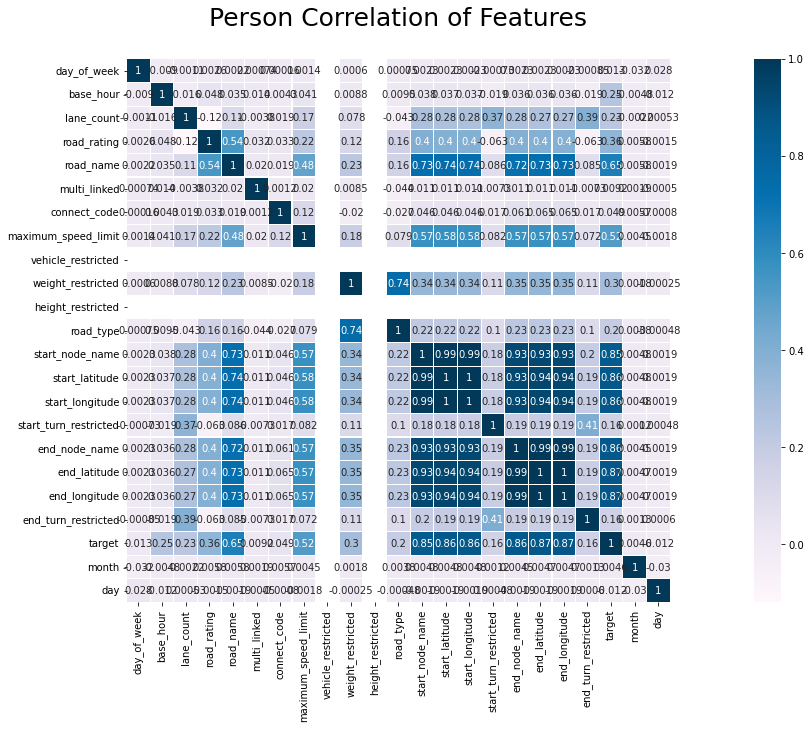

In [6]:
colormap = plt.cm.PuBu
plt.figure(figsize=(30, 10))
plt.title("Person Correlation of Features", y = 1.05, size = 25)
sns.heatmap(df_train.drop(['id','base_date'],axis=1).astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 10})

In [ ]:
# month 생성
# day 생성
# day_of_week 인코딩
# road_name 인코딩
# start_turn_restricted 인코딩
# end_turn_restricted 인코딩
# start_node_name 인코딩
# end_node_name 인코딩

import json

#json data 열기
file_path = "/content/drive/MyDrive/jeju_traffic/json/"
with open(file_path+"day_of_week_mean.json", encoding='utf-8') as f:
    day_of_week_encoder = json.load(f)
    print(day_of_week_encoder)

with open(file_path+"end_node_name_mean.json", encoding='utf-8') as f:
    end_node_name_encoder = json.load(f)
    print(end_node_name_encoder)

with open(file_path+"start_node_name_mean.json", encoding='utf-8') as f:
    start_node_name_encoder = json.load(f)
    print(start_node_name_encoder)

with open(file_path+"road_name_mean.json", encoding='utf-8') as f:
    road_name_encoder = json.load(f)
    print(road_name_encoder)

#####################################################


with open(file_path+"base_hour_mean.json", encoding='utf-8') as f:
    base_hour_encoder = json.load(f)
    print(base_hour_encoder)


with open(file_path+"lane_count_mean.json", encoding='utf-8') as f:
    lane_count_encoder = json.load(f)
    print(lane_count_encoder)



with open(file_path+"road_rating_mean.json", encoding='utf-8') as f:
    road_rating_encoder = json.load(f)
    print(road_rating_encoder)



with open(file_path+"multi_linked_mean.json", encoding='utf-8') as f:
    multi_linked_encoder = json.load(f)
    print(multi_linked_encoder)


#############################################################


with open(file_path+"connect_code_mean.json", encoding='utf-8') as f:
    connect_code_encoder = json.load(f)
    print(connect_code_encoder)


with open(file_path+"maximum_speed_limit_mean.json", encoding='utf-8') as f:
    maximum_speed_limit_encoder = json.load(f)
    print(maximum_speed_limit_encoder)



with open(file_path+"weight_restricted_mean.json", encoding='utf-8') as f:
    weight_restricted_encoder = json.load(f)
    print(weight_restricted_encoder)


with open(file_path+"height_restricted_mean.json", encoding='utf-8') as f:
    height_restricted_encoder = json.load(f)
    print(height_restricted_encoder)


with open(file_path+"road_type_mean.json", encoding='utf-8') as f:
    road_type_encoder = json.load(f)
    print(road_type_encoder)

with open(file_path+"start_turn_restricted_mean.json", encoding='utf-8') as f:
    start_turn_restricted_encoder = json.load(f)
    print(start_turn_restricted_encoder)

    
with open(file_path+"end_turn_restricted_mean.json", encoding='utf-8') as f:
    end_turn_restricted_encoder = json.load(f)
    print(end_turn_restricted_encoder)

with open(file_path+"vehicle_restricted_mean.json", encoding='utf-8') as f:
    vehicle_restricted_encoder = json.load(f)
    print(vehicle_restricted_encoder)

In [ ]:
df_train['month']=df_train['base_date'].apply(lambda x : (x%10000)//100)
df_train['day']=df_train['base_date'].apply(lambda x : (x%10000)%100)
df_train['day_of_week']=df_train['day_of_week'].apply(lambda x : day_of_week_encoder[x])
df_train['road_name']=df_train['road_name'].apply(lambda x : road_name_encoder[x])

# df_train['start_turn_restricted']=df_train['start_turn_restricted'].apply(lambda x : restrict_encoder[x])
# df_train['end_turn_restricted']=df_train['end_turn_restricted'].apply(lambda x : restrict_encoder[x])


df_train['start_node_name']=df_train['start_node_name'].apply(lambda x : start_node_name_encoder[x])
df_train['end_node_name']=df_train['end_node_name'].apply(lambda x : end_node_name_encoder[x])

df_train['base_hour']=df_train['base_hour'].apply(lambda x : base_hour_encoder[str(x)])

df_train['lane_count']=df_train['lane_count'].apply(lambda x : lane_count_encoder[str(x)])

df_train['road_rating']=df_train['road_rating'].apply(lambda x : road_rating_encoder[str(x)])

df_train['multi_linked']=df_train['multi_linked'].apply(lambda x : multi_linked_encoder[str(x)])

df_train['connect_code']=df_train['connect_code'].apply(lambda x : connect_code_encoder[str(x)])

df_train['maximum_speed_limit']=df_train['maximum_speed_limit'].apply(lambda x : maximum_speed_limit_encoder[str(x)])

df_train['weight_restricted']=df_train['weight_restricted'].apply(lambda x : weight_restricted_encoder[str(x)])

df_train['height_restricted']=df_train['height_restricted'].apply(lambda x : height_restricted_encoder[str(x)])

df_train['road_type']=df_train['road_type'].apply(lambda x : road_type_encoder[str(x)])


df_train['start_turn_restricted']=df_train['start_turn_restricted'].apply(lambda x : start_turn_restricted_encoder[str(x)])

df_train['end_turn_restricted']=df_train['end_turn_restricted'].apply(lambda x : end_turn_restricted_encoder[str(x)])

df_train['vehicle_restricted']=df_train['vehicle_restricted'].apply(lambda x : vehicle_restricted_encoder[str(x)])



######################################################


df_validation['month']=df_validation['base_date'].apply(lambda x : (x%10000)//100)
df_validation['day']=df_validation['base_date'].apply(lambda x : (x%10000)%100)
df_validation['day_of_week']=df_validation['day_of_week'].apply(lambda x : day_of_week_encoder[str(x)])
df_validation['road_name']=df_validation['road_name'].apply(lambda x : road_name_encoder[str(x)])

# df_validation['start_turn_restricted']=df_validation['start_turn_restricted'].apply(lambda x : restrict_encoder[x])
# df_validation['end_turn_restricted']=df_validation['end_turn_restricted'].apply(lambda x : restrict_encoder[x])


df_validation['start_node_name']=df_validation['start_node_name'].apply(lambda x : start_node_name_encoder[x])
df_validation['end_node_name']=df_validation['end_node_name'].apply(lambda x : end_node_name_encoder[x])


df_validation['base_hour']=df_validation['base_hour'].apply(lambda x : base_hour_encoder[str(x)])

df_validation['lane_count']=df_validation['lane_count'].apply(lambda x : lane_count_encoder[str(x)])

df_validation['road_rating']=df_validation['road_rating'].apply(lambda x : road_rating_encoder[str(x)])

df_validation['multi_linked']=df_validation['multi_linked'].apply(lambda x : multi_linked_encoder[str(x)])

df_validation['connect_code']=df_validation['connect_code'].apply(lambda x : connect_code_encoder[str(x)])

df_validation['maximum_speed_limit']=df_validation['maximum_speed_limit'].apply(lambda x : maximum_speed_limit_encoder[str(x)])

df_validation['weight_restricted']=df_validation['weight_restricted'].apply(lambda x : weight_restricted_encoder[str(x)])

df_validation['height_restricted']=df_validation['height_restricted'].apply(lambda x : height_restricted_encoder[str(x)])

df_validation['road_type']=df_validation['road_type'].apply(lambda x : road_type_encoder[str(x)])

df_validation['start_turn_restricted']=df_validation['start_turn_restricted'].apply(lambda x : start_turn_restricted_encoder[str(x)])

df_validation['end_turn_restricted']=df_validation['end_turn_restricted'].apply(lambda x : end_turn_restricted_encoder[str(x)])

df_validation['vehicle_restricted']=df_validation['vehicle_restricted'].apply(lambda x : vehicle_restricted_encoder[str(x)])


### 원 핫 인코딩 (One Hot Encoding)


target을 평균으로 잡는 것과 성능이 비슷하나

label class가 너무 많은 columns의 경우는 사용하기 힘듬

둘을 상황에 맞게 사용해야 할것같음


In [46]:
fruit = pd.DataFrame({'name':['apple', 'banana', 'cherry', 'durian', np.nan],
                      'color':['red', 'yellow', 'red', 'green', np.nan]})   #예시 데이터 생성

In [52]:
pd.get_dummies(fruit[['name','color']])

,name_apple,name_banana,name_cherry,name_durian,color_green,color_red,color_yellow
0,1,0,0,0,0,1,0
1,0,1,0,0,0,0,1
2,0,0,1,0,0,1,0
3,0,0,0,1,1,0,0
4,0,0,0,0,0,0,0


In [2]:
df_train=pd.read_parquet('/content/drive/MyDrive/jeju_traffic/train.parquet')

df_train=df_train.sort_values(by=['base_date']) #날짜 순서대로 배치

#시간에 따라 validation 생성 (우리가 예측하는 데이터는 8월 데이터이므로 7월 데이터들을 validation으로 채택)
df_validation=df_train[df_train['base_date']>20220700]
df_train=df_train[df_train['base_date']<20220700]

In [28]:
df_train=df_train[['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted',
       'month', 'day', 'target']]
df_validation=df_validation[['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted', 
       'month', 'day','target']]

x_train = df_train.iloc[:,1:-1]
y_train = df_train.iloc[:,-1]
x_validation=df_validation.iloc[:,1:-1]
y_validation=df_validation.iloc[:,-1]

In [59]:
import gc
gc.collect()

5175

In [23]:
print(df_train.dtypes)
print(x_train.dtypes)

id                        object
base_date                  int64
day_of_week              float64
base_hour                float64
lane_count               float64
road_rating              float64
road_name                float64
multi_linked             float64
connect_code             float64
maximum_speed_limit      float64
vehicle_restricted       float64
weight_restricted        float64
height_restricted        float64
road_type                float64
start_node_name          float64
start_latitude           float64
start_longitude          float64
start_turn_restricted    float64
end_node_name            float64
end_latitude             float64
end_longitude            float64
end_turn_restricted      float64
month                      int64
day                        int64
target                   float64
dtype: object
base_date                  int64
day_of_week              float64
base_hour                float64
lane_count               float64
road_rating              floa

In [4]:


df_train=df_train.astype('str')
df_validation=df_validation.astype('str')
df_train.dtypes

id                        object
base_date                  int64
day_of_week               object
base_hour                  int64
lane_count                 int64
road_rating                int64
road_name                 object
multi_linked               int64
connect_code               int64
maximum_speed_limit      float64
vehicle_restricted       float64
weight_restricted        float64
height_restricted        float64
road_type                  int64
start_node_name           object
start_latitude           float64
start_longitude          float64
start_turn_restricted     object
end_node_name             object
end_latitude             float64
end_longitude            float64
end_turn_restricted       object
target                   float64
dtype: object


id                       object
base_date                object
day_of_week              object
base_hour                object
lane_count               object
road_rating              object
road_name                object
multi_linked             object
connect_code             object
maximum_speed_limit      object
vehicle_restricted       object
weight_restricted        object
height_restricted        object
road_type                object
start_node_name          object
start_latitude           object
start_longitude          object
start_turn_restricted    object
end_node_name            object
end_latitude             object
end_longitude            object
end_turn_restricted      object
target                   object
dtype: object

In [8]:
[1,2,3]+[4,5,6]

[1, 2, 3, 4, 5, 6]

In [30]:
change_columns=[
'road_name',
'road_rating',
'lane_count',
'base_hour',
'maximum_speed_limit',
'weight_restricted',
'road_type',
# 'start_node_name',
# 'end_node_name',
'start_turn_restricted',
'end_turn_restricted',
]

x_train = x_train.astype({i:'str' for i in change_columns })
x_validation = x_validation.astype({i:'str' for i in change_columns })

In [29]:
print(x_train.dtypes)
print(x_validation.dtypes)

base_date                  int64
day_of_week              float64
base_hour                float64
lane_count               float64
road_rating              float64
road_name                float64
multi_linked             float64
connect_code             float64
maximum_speed_limit      float64
vehicle_restricted       float64
weight_restricted        float64
height_restricted        float64
road_type                float64
start_node_name          float64
start_latitude           float64
start_longitude          float64
start_turn_restricted    float64
end_node_name            float64
end_latitude             float64
end_longitude            float64
end_turn_restricted      float64
month                      int64
day                        int64
dtype: object
base_date                  int64
day_of_week              float64
base_hour                float64
lane_count               float64
road_rating              float64
road_name                float64
multi_linked             floa

In [31]:




delete_columns=[
    'day_of_week',
    'start_longitude',
    'start_latitude',
    'end_longitude',
    'end_latitude',
    'base_date',
    'multi_linked',
    'connect_code',
    'vehicle_restricted',
    'height_restricted'
]

x_train=pd.concat([pd.get_dummies(x_train[change_columns])
,x_train], axis=1).drop(
change_columns+delete_columns
,axis=1)

x_validation=pd.concat([pd.get_dummies(x_validation[change_columns])
,x_validation], axis=1).drop(
change_columns+delete_columns
,axis=1)

In [32]:
x_train

,road_name_15.158107599699022,road_name_17.09277177006261,road_name_19.437653272967363,road_name_19.52039621352591,road_name_22.39243233117917,road_name_22.75891677675033,road_name_23.44413329599552,road_name_23.895855701095126,road_name_24.51610665080781,road_name_24.79321344434527,...,road_type_41.5819481186086,road_type_49.44865015799017,start_turn_restricted_35.502837181724885,start_turn_restricted_43.998171749701676,end_turn_restricted_35.20886796135919,end_turn_restricted_44.029238118153536,start_node_name,end_node_name,month,day
430379,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,25.866071,32.427174,9,1
369019,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,43.367480,43.519760,9,1
1132647,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,39.874767,48.110270,9,1
4543127,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,59.376035,56.740673,9,1
3428956,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,54.528350,53.163413,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3951630,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,24.130198,27.126282,6,30
1586581,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,50.085341,50.085387,6,30
3665493,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,63.534937,52.259623,6,30
3371207,0,0,0,0,0,0,0,0,0,1,...,1,0,0,1,0,1,25.682868,30.881452,6,30


In [34]:
print(len(x_train.columns))
print(len(x_validation.columns))
print()
x_train=x_train.drop(list(set(x_train.columns) -set(x_validation)),axis=1)

print(len(x_train.columns))
print(len(x_validation.columns))

111
106

106
106


In [35]:
mlr = LinearRegression()
mlr.fit(x_train, y_train) 


# 모델성능 측정
# train MAE
train_predict = mlr.predict(x_train)

print("MAE':{}".format((mean_absolute_error(train_predict, y_train))) )
 
# validation MAE
valid_predict = mlr.predict(x_validation)
print("MAE':{}".format((mean_absolute_error(valid_predict, y_validation))) )

MAE':5.214341777750734
MAE':5.255415878359322


## 모델 실행

### 1. XGB

RF와 같이 Decision Tree기반 모델중 대표적인 모델이다

GPU환경에서 예측 할수있는것이 가장큰 특징인것 같다.

속도가 RF에 비해 압도적으로 빠르다.

인코딩기법이나 스케일링에 큰 영향을 받지 않는듯 하다.

오히려 columns을 반정규화 했을때 성능이 향상되는 경우도 보였다.

ex) 시작, 끝 지점의 위도와 경도를 지웠을때 예측 성능이 떨어짐....

In [ ]:
df_train=df_train[['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted',
       'month', 'day', 'target']]
df_validation=df_validation[['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted', 
       'month', 'day','target']]


x_train = df_train.iloc[:,1:-1]
y_train = df_train.iloc[:,-1]
x_validation=df_validation.iloc[:,1:-1]
y_validation=df_validation.iloc[:,-1]

In [ ]:
# subsample=0.8, colsample_bytree=0.6 -> 3.564

import time

start = time.time()

xgb_run = xgboost.XGBRegressor(random_state=42, 
                              tree_method='gpu_hist', 
                              booster='gbtree',
                              gpu_id=0,
                              max_depth=15,
                              learning_rate=0.08,
                              gamma=0,
                              subsample=1,
                              colsample_bytree=0.8,
                              reg_lambda=1,
                              reg_alpha=0,
                              rate_drop=0,
                              n_estimators=800
                              )
xgb_run.fit(x_train, y_train,
            early_stopping_rounds=100,
            eval_metric='mae',
            eval_set=[(x_train, y_train),(x_validation, y_validation)]
            )



print(str((time.time()-start)//3600) +' hours ' + str(((time.time()-start)%3600)//60) + ' minute ' + str((time.time()-start)%60) + ' second')

In [ ]:

ftr_importances_values = xgb_run.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=x_train.columns)
ftr_top = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(16, 12))
sns.barplot(x=ftr_top, y=ftr_top.index)

### 2. RF

In [ ]:
df_train=df_train[['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted',
       'month', 'day', 'target']]
df_validation=df_validation[['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted', 
       'month', 'day','target']]


x_train = df_train.iloc[:,1:-1]
y_train = df_train.iloc[:,-1]
x_validation=df_validation.iloc[:,1:-1]
y_validation=df_validation.iloc[:,-1]

In [ ]:
import gc
#약  48분
rf_run = RandomForestRegressor(random_state=42, max_depth=10,min_samples_split=10,min_samples_leaf=10,n_estimators=100)
rf_run.fit(x_train, y_train)

# 모델성능 측정
# train MAE
train_predict = rf_run.predict(x_train)

print("MAE':{}".format((mean_absolute_error(train_predict, y_train))) )
 
# validation MAE
valid_predict = rf_run.predict(x_validation)
print("MAE':{}".format((mean_absolute_error(valid_predict, y_validation))) )

### 3. Multiple Linear Regression 

encoding 하는 방법이 꽤 중요한듯 하다.

데이터 그자체에 인사이트가 많을때 가장 빠르고 효율적인 모델이지 않나 싶다.

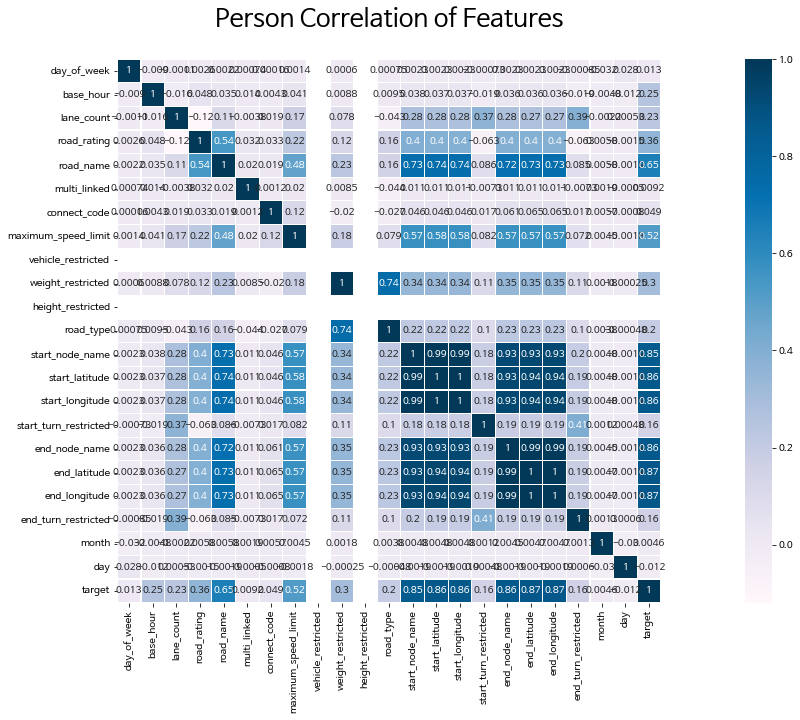

In [32]:
colormap = plt.cm.PuBu
plt.figure(figsize=(30, 10))
plt.title("Person Correlation of Features", y = 1.05, size = 25)
sns.heatmap(df_train.drop(['id','base_date'],axis=1).astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 10})

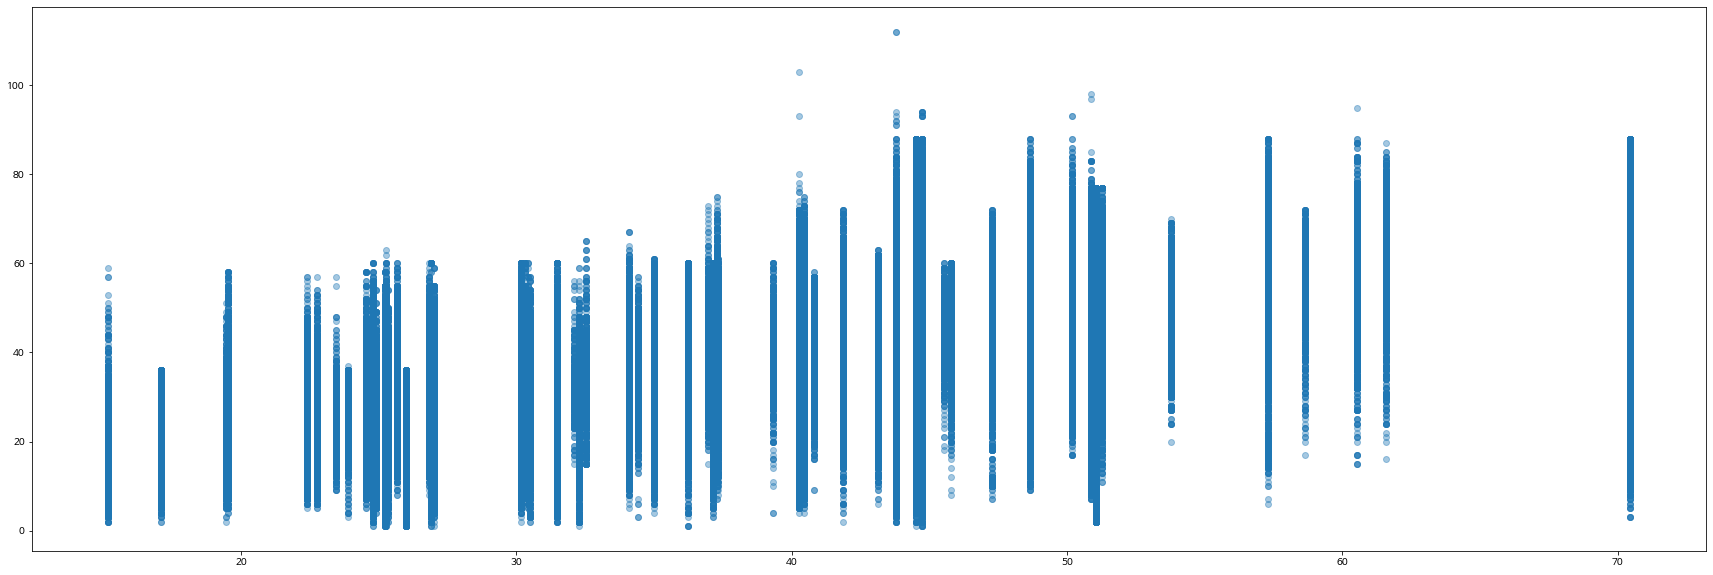

In [38]:
plt.figure(figsize=(30,10))
plt.scatter(df_train[['road_name']], df_train[['target']], alpha=0.4)
plt.show()

In [34]:
#공산성이 높은 변수들제거 해주고 상관계수가 많이 낮은 변수들을 제거해줬더니 오히려 성능이 떨어짐

df_train=df_train[['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted',
       'month', 'day', 'target']]
df_validation=df_validation[['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted', 
       'month', 'day','target']]




x_train = df_train.drop(['base_date',
'day_of_week',
'multi_linked',
'connect_code',
'vehicle_restricted',
'height_restricted',
'start_longitude',
'start_latitude',
'end_longitude',
'end_latitude',
'month',
'day'],axis=1).iloc[:,1:-1]

y_train = df_train.drop(['base_date',
'day_of_week',
'multi_linked',
'connect_code',
'vehicle_restricted',
'height_restricted',
'start_longitude',
'start_latitude',
'end_longitude',
'end_latitude',
'month',
'day'],axis=1).iloc[:,-1]

x_validation=df_validation.drop(['base_date',
'day_of_week',
'multi_linked',
'connect_code',
'vehicle_restricted',
'height_restricted',
'start_longitude',
'start_latitude',
'end_longitude',
'end_latitude',
'month',
'day'],axis=1).iloc[:,1:-1]

y_validation=df_validation.drop(['base_date',
'day_of_week',
'multi_linked',
'connect_code',
'vehicle_restricted',
'height_restricted',
'start_longitude',
'start_latitude',
'end_longitude',
'end_latitude',
'month',
'day'],axis=1).iloc[:,-1]

mlr = LinearRegression()
mlr.fit(x_train, y_train) 


# 모델성능 측정
# train MAE
train_predict = mlr.predict(x_train)

print("MAE':{}".format((mean_absolute_error(train_predict, y_train))) )
 
# validation MAE
valid_predict = mlr.predict(x_validation)
print("MAE':{}".format((mean_absolute_error(valid_predict, y_validation))) )

MAE':5.2541895316905
MAE':5.31242337608738


In [33]:
df_train=df_train[['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted',
       'month', 'day', 'target']]
df_validation=df_validation[['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted', 
       'month', 'day','target']]




x_train = df_train.drop(['base_date',],axis=1).iloc[:,1:-1]

y_train = df_train.drop(['base_date',],axis=1).iloc[:,-1]

x_validation=df_validation.drop(['base_date',],axis=1).iloc[:,1:-1]

y_validation=df_validation.drop(['base_date',],axis=1).iloc[:,-1]

mlr = LinearRegression()
mlr.fit(x_train, y_train) 


# 모델성능 측정
# train MAE
train_predict = mlr.predict(x_train)

print("MAE':{}".format((mean_absolute_error(train_predict, y_train))) )
 
# validation MAE
valid_predict = mlr.predict(x_validation)
print("MAE':{}".format((mean_absolute_error(valid_predict, y_validation))) )



MAE':5.02002886519872
MAE':5.183518481289729


## 모델 반복 실행 및 기록


RF 모델 grid search 사용하는것 보다 그냥 쌩으로 돌리는게 시간이 덜 걸리기도하고

각 파라미터와 validation metric 증감도 대략적으로 알고싶기에 모든 기록을 남기기로했다.

### 1. XGB

특징을 적어보도록 하자

In [ ]:
# XGBmodel_record=pd.DataFrame({'model_version':[],'hyperparameter':[],'validation_MAE':[],'runtime':[]})

# XGBmodel_record.to_csv('/content/drive/MyDrive/jeju_traffic/result/XGBmodel_record.csv',index=False)

In [ ]:
re=pd.read_csv('/content/drive/MyDrive/jeju_traffic/result/XGBmodel_record.csv')
re

In [ ]:
params = {
    'random_state':       (42,42,42,42,42,42, 42,42,42,42,42,42,  42,42,42,42,42,42,   42,42,42,42,42,42,   42,42,42,42,42,42,  42,42,42,42,42,42,),
    'max_depth' :         (15,15,15,15,15,15, 15,15,15,15,15,15, 15,15,15,15,15,15, 15,15,15,15,15,15, 15,15,15,15,15,15, 15,15,15,15,15,15,),
    'learning_rate':      (0.08,0.08,0.08,0.08,0.08,0.08, 0.08,0.08,0.08,0.08,0.08,0.08, 0.08,0.08,0.08,0.08,0.08,0.08, 0.08,0.08,0.08,0.08,0.08,0.08, 0.08,0.08,0.08,0.08,0.08,0.08, 0.08,0.08,0.08,0.08,0.08,0.08,),
    'subsample':          (0.8,0.8,0.8,0.8,0.8,0.8, 0.8,0.8,0.8,0.8,0.8,0.8, 0.8,0.8,0.8,0.8,0.8,0.8, 0.8,0.8,0.8,0.8,0.8,0.8, 0.8,0.8,0.8,0.8,0.8,0.8, 0.8,0.8,0.8,0.8,0.8,0.8,),
    'colsample_bytree':   (0.6,0.6,0.6,0.6,0.6, 0.6,0.6,0.6,0.6,0.6, 0.6,0.6,0.6,0.6,0.6, 0.6,0.6,0.6,0.6,0.6, 0.6,0.6,0.6,0.6,0.6, 0.6,0.6,0.6,0.6,0.6, 0.6,0.6,0.6,0.6,0.6,0.6, ),
    'rate_drop':          (0,0,0,0,0, 0, 0,0,0,0,0, 0, 0,0,0,0,0, 0, 0,0,0,0,0, 0, 0,0,0,0,0, 0, 0,0,0,0,0, 0, ),
    'gamma':              (0,0.1,0.2,0.3,0.4,0.5,   0,0.1,0.2,0.3,0.4,0.5,   0,0.1,0.2,0.3,0.4,0.5,   0,0.1,0.2,0.3,0.4,0.5,   0,0.1,0.2,0.3,0.4,0.5,  0,0.1,0.2,0.3,0.4,0.5,),
    'reg_lambda' :        (1,1,1,1,1,1,    0.9,0.9,0.9,0.9,0.9,0.9,   0.8,0.8,0.8,0.8,0.8,0.8,   0.7,0.7,0.7,0.7,0.7,0.7 ,  0.6,0.6,0.6,0.6,0.6,0.6,   0.5,0.5,0.5,0.5,0.5,0.5),
    'reg_alpha' :         (0,0,0,0,0,0,    0.1,0.1,0.1,0.1,0.1,0.1,   0.2,0.2,0.2,0.2,0.2,0.2,   0.3,0.3,0.3,0.3,0.3,0.3,   0.4,0.4,0.4,0.4,0.4,0.4 ,  0.5,0.5,0.5,0.5,0.5,0.5),
}



params_df=pd.DataFrame.from_dict(params)

params_df

In [ ]:

for idx,i in enumerate(params_df.iterrows()):
  # print(i)
  # print('===')
  
  XGBmodel_record=pd.read_csv('/content/drive/MyDrive/jeju_traffic/result/XGBmodel_record.csv')
  # record=pd.DataFrame({'model_version':[],'hyperparameter':[],'validation_MAE':[],'runtime':[]})
  record={}
  print(idx)
  numbering=len(XGBmodel_record)+idx
  start = time.time()
  record['model_version']=['rf_run_{}'.format(numbering)]
  record['hyperparameter']=['random_state: '+str(params['random_state'][idx]) +' '+',max_depth: '+str(params['max_depth'][idx]) +' '+',learning_rate: '+str(params['learning_rate'][idx])+' '+',subsample: '+str(params['subsample'][idx])+' '+',colsample_bytree: '+str(params['colsample_bytree'][idx])+' '+',rate_drop: '+str(params['rate_drop'][idx])+' '+',gamma: '+str(params['gamma'][idx]) +' '+',lambda: '+str(params['reg_lambda'][idx]) +' '+',alpha: '+str(params['reg_alpha'][idx]) ]
  
  # print(record)

  xgb_run = xgboost.XGBRegressor(random_state=params['random_state'][idx], 
                                 tree_method='gpu_hist', 
                                 booster='gbtree',
                                 gpu_id=0,
                                 max_depth=params['max_depth'][idx],
                                 learning_rate=params['learning_rate'][idx],
                                 subsample=params['subsample'][idx],
                                 colsample_bytree=params['colsample_bytree'][idx],
                                 rate_drop=params['rate_drop'][idx],
                                 n_estimators=400,
                                 gamma=params['gamma'][idx],
                                 reg_lambda = 1,
                                 reg_alpha = 0,
                                 )
  xgb_run.fit(x_train, y_train,
            early_stopping_rounds=150,
            eval_metric='mae',
            eval_set=[(x_train, y_train),(x_validation, y_validation)]
            )

  
  
  valid_predict = xgb_run.predict(x_validation)
  record['validation_MAE']=[mean_absolute_error(valid_predict, y_validation)]

  record['runtime']= [str((time.time()-start)//3600) +' hours ' + str(((time.time()-start)%3600)//60) + ' minute ' + str((time.time()-start)%60) + ' second' ] 

  record_df=pd.DataFrame.from_dict(record)

  XGBmodel_record = XGBmodel_record.append(record_df, ignore_index = True)

  XGBmodel_record.to_csv('/content/drive/MyDrive/jeju_traffic/result/XGBmodel_record.csv',index=False)
  
  print('hyperparameter')
  print(i[1])  
  print("MAE':{}".format((mean_absolute_error(valid_predict, y_validation))) )
  print('==='*100)

  ftr_importances_values = xgb_run.feature_importances_
  ftr_importances = pd.Series(ftr_importances_values, index=x_train.columns)
  ftr_top = ftr_importances.sort_values(ascending=False)[:20]
  plt.figure(figsize=(16, 12))
  sns.barplot(x=ftr_top, y=ftr_top.index)
  plt.savefig('/content/drive/MyDrive/jeju_traffic/result/feature_importance_image/' + 'xgb_run_{}'.format(numbering) + '.png')



df=pd.read_csv('/content/drive/MyDrive/jeju_traffic/result/XGBmodel_record.csv')

df.sort_values(by='validation_MAE',ascending=False,ignore_index=False)

print(df.loc[0,['hyperparameter','validation_MAE']])
print(df.loc[1,['hyperparameter','validation_MAE']])
print(df.loc[2,['hyperparameter','validation_MAE']])
print(df.loc[3,['hyperparameter','validation_MAE']])

### 2.RF

특징을 적어보도록 하자

In [ ]:
# RFmodel_record=pd.DataFrame({'model_version':[],'hyperparameter':[],'validation_MAE':[],'runtime':[]})

# RFmodel_record.to_csv('/content/drive/MyDrive/jeju_traffic/result/RFmodel_record.csv',index=False)

re=pd.read_csv('/content/drive/MyDrive/jeju_traffic/result/RFmodel_record.csv')
re

In [ ]:
import pandas as pd
import time
import matplotlib.pyplot as plt # 득점모델 변수 중요도
import seaborn as sns


params = {
    'random_state':       (42, 42, 42,42),
    'max_depth' :         (20,21,22,23),
    'min_samples_split' : (8, 8, 8,8),
    'min_samples_leaf' :  (8, 8, 8,8),
    'n_estimators':       (200, 200, 200,200),
}

params_df=pd.DataFrame.from_dict(params)




for idx,i in enumerate(params_df.iterrows()):
  # print(i)
  # print('===')
  
  RFmodel_record=pd.read_csv('/content/drive/MyDrive/jeju_traffic/result/RFmodel_record.csv')
  # record=pd.DataFrame({'model_version':[],'hyperparameter':[],'validation_MAE':[],'runtime':[]})
  record={}
  print(idx)
  numbering=len(RFmodel_record)+idx
  start = time.time()
  record['model_version']=['rf_run_{}'.format(numbering)]
  record['hyperparameter']=['random_state: '+str(params['random_state'][idx]) +' '+',max_depth: '+str(params['max_depth'][idx]) +' '+',min_samples_split: '+str(params['min_samples_split'][idx])+' '+',min_samples_leaf: '+str(params['min_samples_leaf'][idx])+' '+',n_estimators: '+str(params['n_estimators'][idx])]
  
  # print(record)

  rf_run = RandomForestRegressor(n_jobs=-1,random_state=params['random_state'][idx], max_depth=params['max_depth'][idx],min_samples_split=params['min_samples_split'][idx],min_samples_leaf=params['min_samples_leaf'][idx],n_estimators=params['n_estimators'][idx])
  rf_run.fit(x_train, y_train,
            # early_stopping_rounds=150,
            # eval_metric='mae',
            # eval_set=[(x_train, y_train),(x_validation, y_validation)]
             )

  
  train_predict = rf_run.predict(x_train)
  valid_predict = rf_run.predict(x_validation)

  record['validation_MAE']=[mean_absolute_error(valid_predict, y_validation)]

  record['runtime']= [str((time.time()-start)//3600) +' hours ' + str(((time.time()-start)%3600)//60) + ' minute ' + str((time.time()-start)%60) + ' second' ] 

  record_df=pd.DataFrame.from_dict(record)

  RFmodel_record = RFmodel_record.append(record_df, ignore_index = True)

  RFmodel_record.to_csv('/content/drive/MyDrive/jeju_traffic/result/RFmodel_record.csv',index=False)
  
  print('hyperparameter')
  print(i[1])  
  

  print("MAE':{}".format((mean_absolute_error(train_predict, y_train))) )
  print("MAE':{}".format((mean_absolute_error(valid_predict, y_validation))) )
  print(str((time.time()-start)//3600) +' hours ' + str(((time.time()-start)%3600)//60) + ' minute ' + str((time.time()-start)%60) + ' second')
  print('==='*100)

  ftr_importances_values = rf_run.feature_importances_
  ftr_importances = pd.Series(ftr_importances_values, index=x_train.columns)
  ftr_top = ftr_importances.sort_values(ascending=False)[:20]
  plt.figure(figsize=(16, 12))
  sns.barplot(x=ftr_top, y=ftr_top.index)
  plt.savefig('/content/drive/MyDrive/jeju_traffic/result/feature_importance_image/' + 'rf_run_{}'.format(numbering) + '.png')







In [ ]:

# df=pd.read_csv('/content/drive/MyDrive/jeju_traffic/result/RFmodel_record.csv')

# df.sort_values(by='validation_MAE',ascending=False,ignore_index=False)

# print(df.loc[0,['hyperparameter','validation_MAE']])
# print(df.loc[1,['hyperparameter','validation_MAE']])
# print(df.loc[2,['hyperparameter','validation_MAE']])
# print(df.loc[3,['hyperparameter','validation_MAE']])


### 3. Linear Regression

# submission 제출

In [ ]:

df_train=pd.read_parquet('/content/drive/MyDrive/jeju_traffic/train_preprocess.parquet')
df_validation=pd.read_parquet('/content/drive/MyDrive/jeju_traffic/validation_preprocess.parquet')
df_test=pd.read_parquet('/content/drive/MyDrive/jeju_traffic/test_preprocess.parquet')

In [ ]:
df_train=df_train[['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted',
       'month', 'day', 'target']]
df_validation=df_validation[['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted', 
       'month', 'day','target']]
# #['base_date','month','end_turn_restricted','start_turn_restricted','vehicle_restricted','height_restricted','day_of_week','connect_code','multi_linked','day']
# df_train.drop(['start_latitude','start_longitude','end_latitude','end_longitude','base_date','month','end_turn_restricted','start_turn_restricted','vehicle_restricted','height_restricted','day_of_week','connect_code','multi_linked','day'],axis=1,inplace=True)
# df_validation.drop(['start_latitude','start_longitude','end_latitude','end_longitude','base_date','month','end_turn_restricted','start_turn_restricted','vehicle_restricted','height_restricted','day_of_week','connect_code','multi_linked','day'],axis=1,inplace=True)
# df_test.drop(['start_latitude','start_longitude','end_latitude','end_longitude','base_date','month','end_turn_restricted','start_turn_restricted','vehicle_restricted','height_restricted','day_of_week','connect_code','multi_linked','day'],axis=1,inplace=True)

In [ ]:
x_train = df_train.iloc[:,1:-1]
y_train = df_train.iloc[:,-1]
x_validation=df_validation.iloc[:,1:-1]
y_validation=df_validation.iloc[:,-1]

In [ ]:
x_train=pd.concat([x_train,x_validation]).reset_index(drop=True)
y_train=pd.concat([y_train,y_validation]).reset_index(drop=True)

In [ ]:
x_test=df_test.iloc[:,1:]

In [ ]:
# 가장 성능이 잘나온 parameter를 입력해주세요

xgb_run = xgboost.XGBRegressor(random_state=42, 
                              tree_method='gpu_hist', 
                              booster='gbtree',
                              gpu_id=0,
                              max_depth=15,
                              learning_rate=0.04,
                              gamma=0,
                              subsample=0.8,
                              colsample_bytree=1,
                              rate_drop=0,
                              reg_lambda=1,
                              reg_alpha=0,
                              n_estimators=400
                              )

# max_depth: 15 ,learning_rate: 0.08 ,gamma: 0 ,subsample: 0.8 ,colsample_bytree: 1 ,rate_drop: 0

            

In [ ]:
submission=pd.read_csv('/content/drive/MyDrive/jeju_traffic/sample_submission.csv')


submission['target']=xgb_run.predict(x_test)



submission.to_csv('/content/drive/MyDrive/jeju_traffic/result/standard_XGB_max_depth: 15 ,learning_rate: 0.04 ,gamma: 0 ,subsample: 0.8 ,colsample_bytree: 1 ,rate_drop: 0.csv',index=False)